In [140]:
%load_ext autoreload
%autoreload 2
import torch
import imageio
import sys
import io
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
sys.path.append("../radialmri/")
from simulation_and_reconstruction import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filedir = '/gpfs/home/zh1115/knolllabspace/hzn/storage/newsimulation/simulated_20210128/sim_PT13.mat'
dataload = loadmat(filedir)
print(dataload.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ID', 'S0', 'aif', 'cts', 'mask', 'parMap', 'simImg', 'smap_complex'])


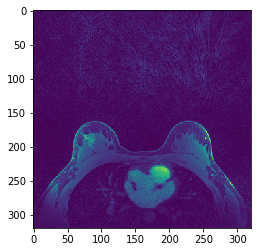

In [3]:
plt.imshow(np.abs(dataload['simImg'][:, :, 9]))
plt.show()

In [4]:
masksloaded = dataload['mask']

simulated_image = dataload['simImg']
simulated_image = np.flipud(np.array(simulated_image))#flip up and down

simulated_target = np.array(simulated_image, dtype='complex128')
simulated_target = simulated_target.swapaxes(0, 2).swapaxes(1, 2)
#print(simulated_target.shape, simulated_target.dtype)

target = np.stack((simulated_target.real, simulated_target.imag), axis=1)
target = torch.tensor(target, dtype=dtype, device=device)


In [5]:
smap_complex = dataload['smap_complex']
smap_loaded = numpy2torch(smap_complex, device =device)
smap_loaded = smap_loaded.permute(1,0,2,3).unsqueeze(0)

In [6]:
nt = 22
temporal_coilimg = np.array([sim_coil(simulated_target[i,:,:], smap_complex, coild=0) for i in range(nt)])

target_recombine= np.array([temporal_coilimg[:,i]*np.conj(smap_complex[i,:,:]) for i in range(temporal_coilimg.shape[1])])
target_recombine= np.sum(target_recombine, axis=0)

In [7]:
print("target.shape", target.shape, target.dtype,\
      "smap.shape", smap_loaded.shape, smap_loaded.dtype)

simulated_kspace_21, recon_fromsim_21, traj_21, dcomp_21 \
= RadialSimulation(target = target,
                   spokespertime=21,
                   nt=nt, nc=16,
                   spokelength=640,
                   smap=smap_loaded,
                   grid_size = (640, 640),
                   im_size= (320, 320))

recon_fromsim_21 = torch2numpy(recon_fromsim_21.permute(0,2,3,1))

target.shape torch.Size([22, 2, 320, 320]) torch.float32 smap.shape torch.Size([1, 16, 2, 320, 320]) torch.float32
torch.Size([22, 16, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


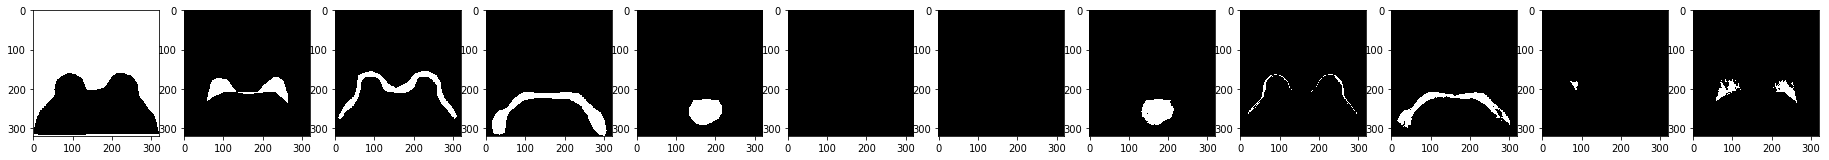

In [8]:
plotcoil(masksloaded[0][0], n = 12, cmap = 'gray')

## Original Density Compensation

torch.Size([22, 2, 320, 320])


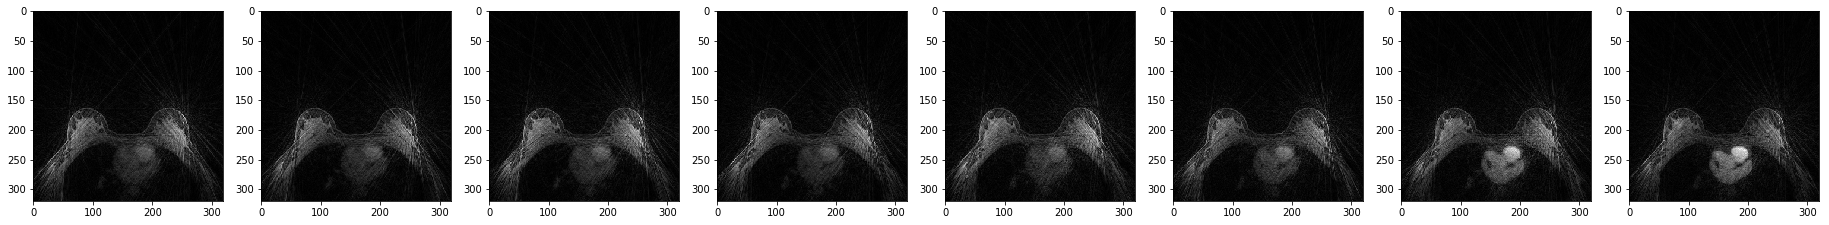

(22,)


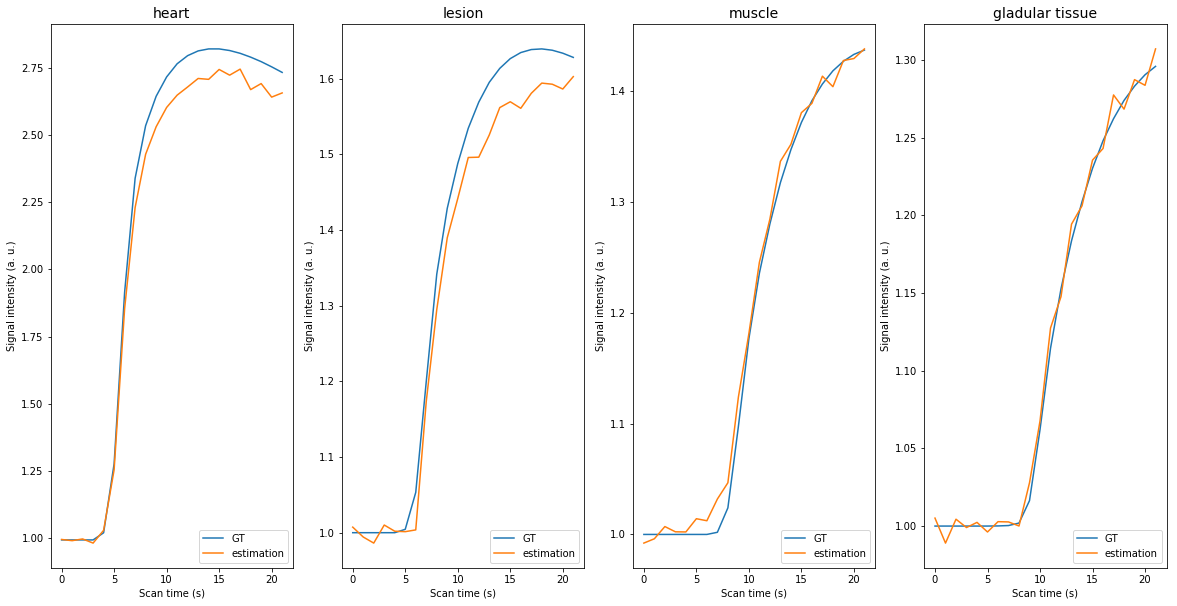

In [11]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_21.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft.shape)
adjnufft = torch.sqrt(adj_nufft[:, 0]**2 + adj_nufft[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Updated Density Compensation

In [12]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp

dcomp_FL = dcomp_reference(traj_21, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

torch.Size([22, 16, 2, 13440]) cpu


torch.Size([22, 2, 320, 320])


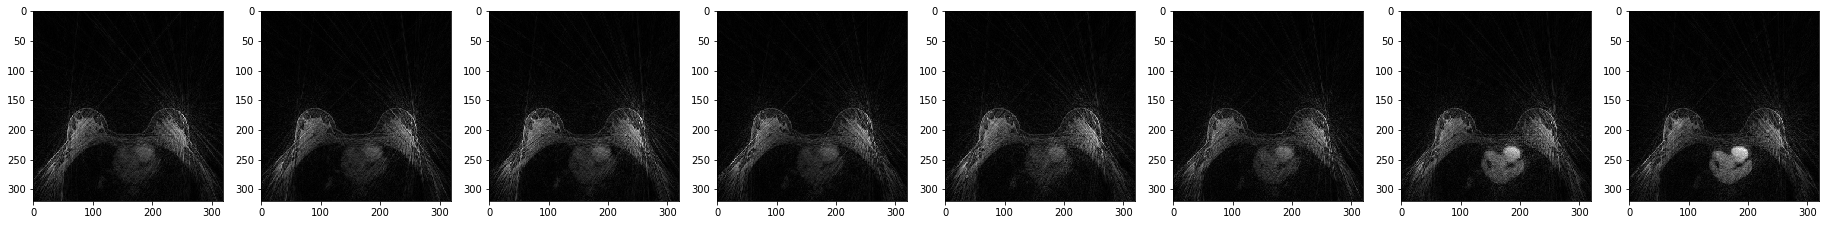

(22,)


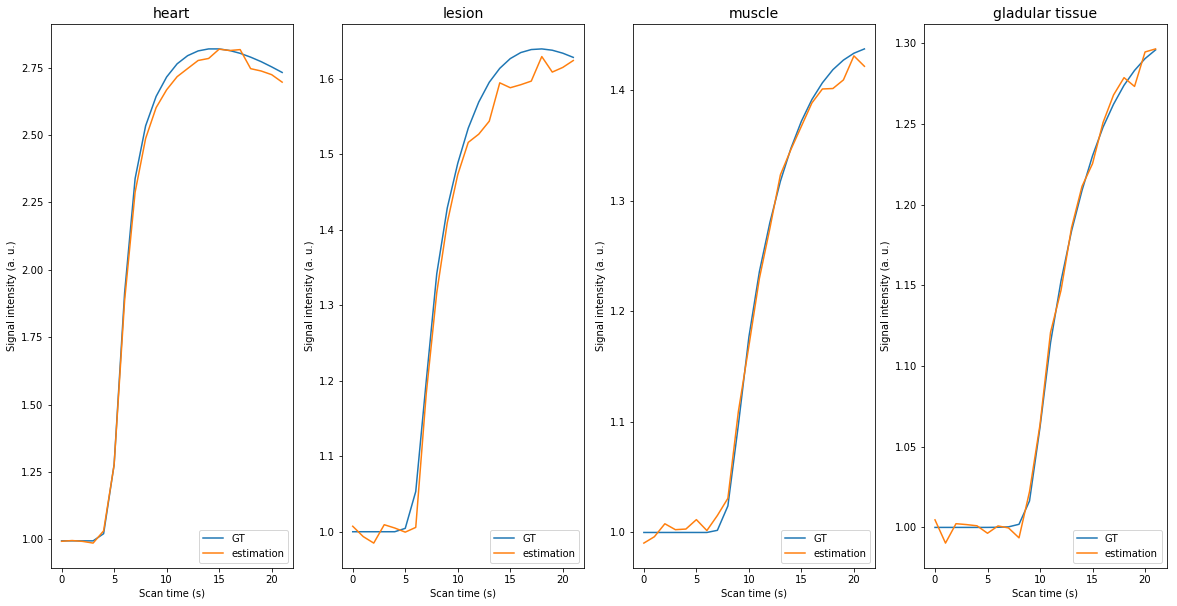

In [13]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 3.0571e+01, -3.2382e-07], device='cuda:0')
1 alpha:  tensor([ 1.1778e+01, -1.1334e-07], device='cuda:0')
2 alpha:  tensor([ 9.9164e+00, -3.3056e-08], device='cuda:0')
3 alpha:  tensor([ 1.0760e+01, -2.7812e-08], device='cuda:0')
4 alpha:  tensor([ 1.2860e+01, -3.4866e-08], device='cuda:0')
5 alpha:  tensor([ 1.5027e+01, -4.7135e-08], device='cuda:0')
6 alpha:  tensor([ 1.5325e+01, -5.8972e-08], device='cuda:0')
7 alpha:  tensor([ 1.4891e+01, -5.1877e-08], device='cuda:0')
8 alpha:  tensor([ 1.4790e+01, -3.8950e-08], device='cuda:0')
9 alpha:  tensor([ 1.6089e+01, -2.1145e-08], device='cuda:0')
10 alpha:  tensor([ 1.7236e+01, -1.2408e-08], device='cuda:0')
11 alpha:  tensor([ 1.6879e+01, -1.6226e-08], device='cuda:0')
12 alpha:  tensor([ 1.5911e+01, -4.5111e-08], device='cuda:0')
13 alpha:  tensor([ 1.6072e+01, -1.5929e-08], device='cuda:0')
14 alpha:  tensor([ 1.6681e+01, -4.8169e-09], device='cuda:0')
15 alpha:  tensor([1.7531e+01, 2.5238e-09], device='cuda:0')
16 a

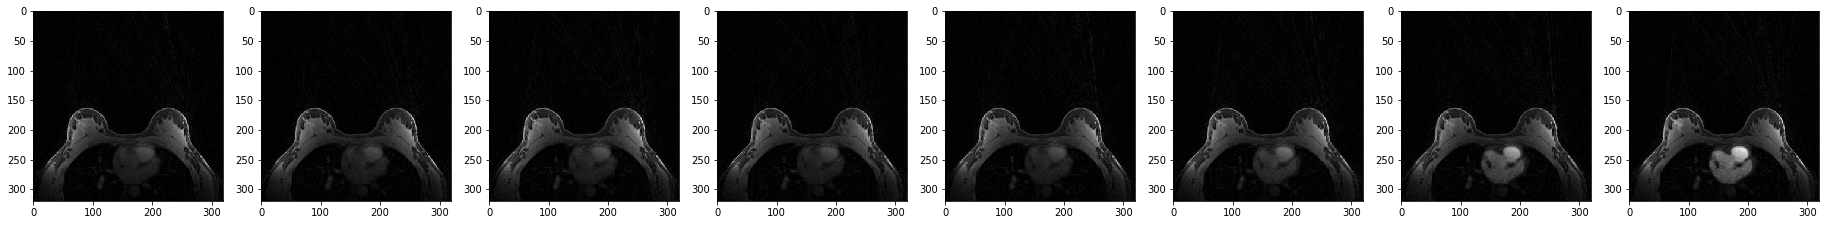

(22,)


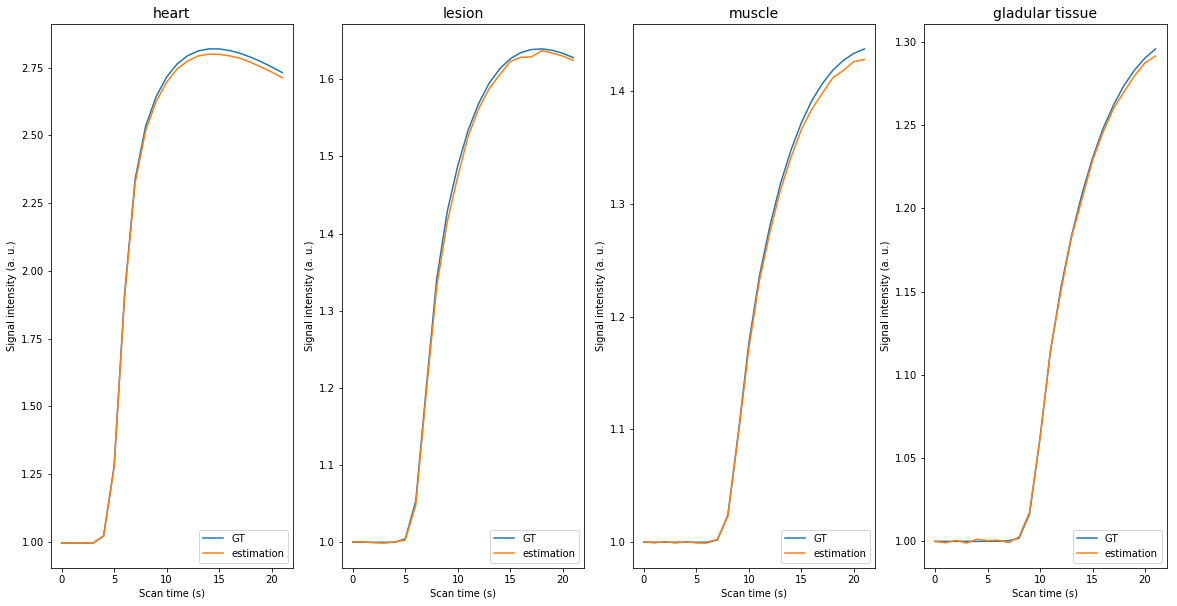

In [65]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 3.0571e+01, -3.3128e-07], device='cuda:0')
1 alpha:  tensor([ 1.1778e+01, -1.1303e-07], device='cuda:0')
2 alpha:  tensor([ 9.9164e+00, -3.6121e-08], device='cuda:0')
3 alpha:  tensor([ 1.0760e+01, -2.8996e-08], device='cuda:0')
4 alpha:  tensor([ 1.2860e+01, -4.0089e-08], device='cuda:0')
5 alpha:  tensor([ 1.5027e+01, -5.5634e-08], device='cuda:0')
6 alpha:  tensor([ 1.5325e+01, -4.7301e-08], device='cuda:0')
7 alpha:  tensor([ 1.4891e+01, -4.9641e-08], device='cuda:0')
8 alpha:  tensor([ 1.4790e+01, -4.1835e-08], device='cuda:0')
9 alpha:  tensor([ 1.6089e+01, -1.8501e-08], device='cuda:0')
10 alpha:  tensor([ 1.7236e+01, -4.0564e-09], device='cuda:0')
11 alpha:  tensor([ 1.6879e+01, -2.8396e-08], device='cuda:0')
12 alpha:  tensor([ 1.5911e+01, -3.9299e-08], device='cuda:0')
13 alpha:  tensor([ 1.6072e+01, -2.0708e-08], device='cuda:0')
14 alpha:  tensor([1.6681e+01, 6.6233e-09], device='cuda:0')
15 alpha:  tensor([1.7531e+01, 5.0476e-09], device='cuda:0')
16 alp

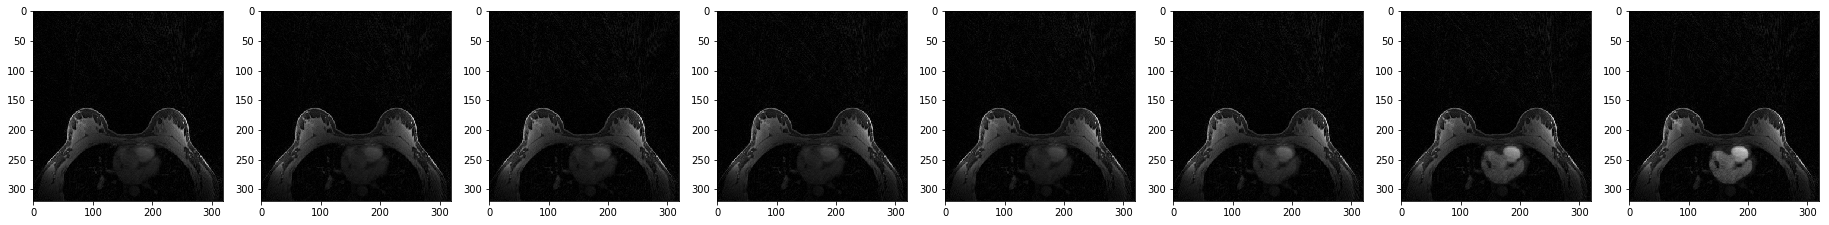

(22,)


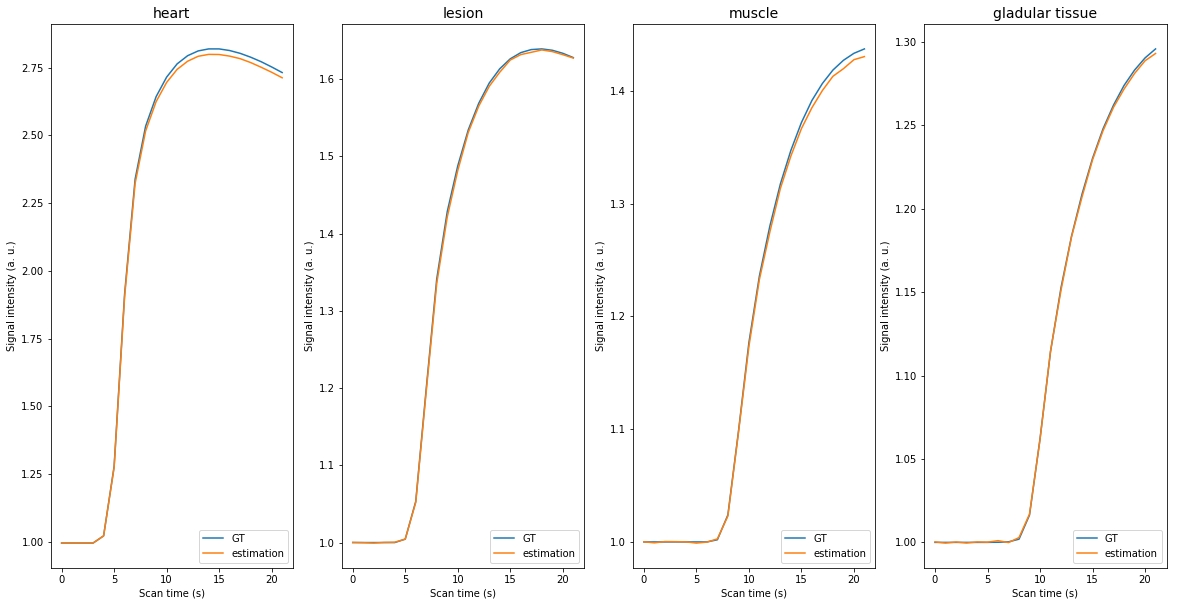

In [66]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Using the original density compensation

0 alpha:  tensor([ 3.0757e+01, -4.9770e-07], device='cuda:0')
1 alpha:  tensor([ 1.0367e+01, -8.7462e-08], device='cuda:0')
2 alpha:  tensor([ 9.7923e+00, -2.4255e-08], device='cuda:0')
3 alpha:  tensor([ 1.1815e+01, -3.7729e-08], device='cuda:0')
4 alpha:  tensor([ 1.4596e+01, -9.0509e-08], device='cuda:0')
5 alpha:  tensor([ 1.4683e+01, -1.1202e-07], device='cuda:0')
6 alpha:  tensor([ 1.3624e+01, -5.9982e-08], device='cuda:0')
7 alpha:  tensor([ 1.4719e+01, -2.9511e-08], device='cuda:0')
8 alpha:  tensor([ 1.6681e+01, -5.6019e-08], device='cuda:0')
9 alpha:  tensor([ 1.7069e+01, -9.7393e-08], device='cuda:0')
10 alpha:  tensor([ 1.5539e+01, -6.0221e-08], device='cuda:0')
11 alpha:  tensor([ 1.5168e+01, -4.5752e-08], device='cuda:0')
12 alpha:  tensor([ 1.6614e+01, -4.0071e-08], device='cuda:0')
13 alpha:  tensor([ 1.7904e+01, -4.6715e-08], device='cuda:0')
14 alpha:  tensor([ 1.6658e+01, -4.2666e-08], device='cuda:0')
15 alpha:  tensor([ 1.6048e+01, -1.8096e-08], device='cuda:0')
16

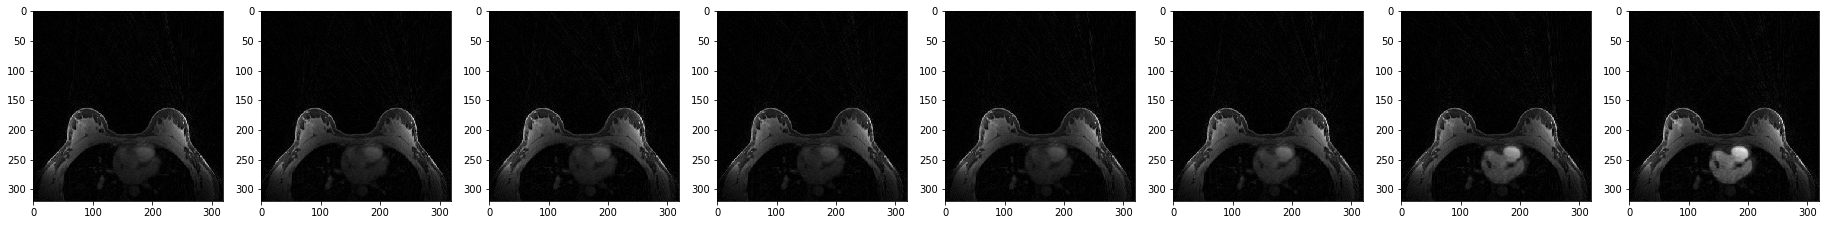

(22,)


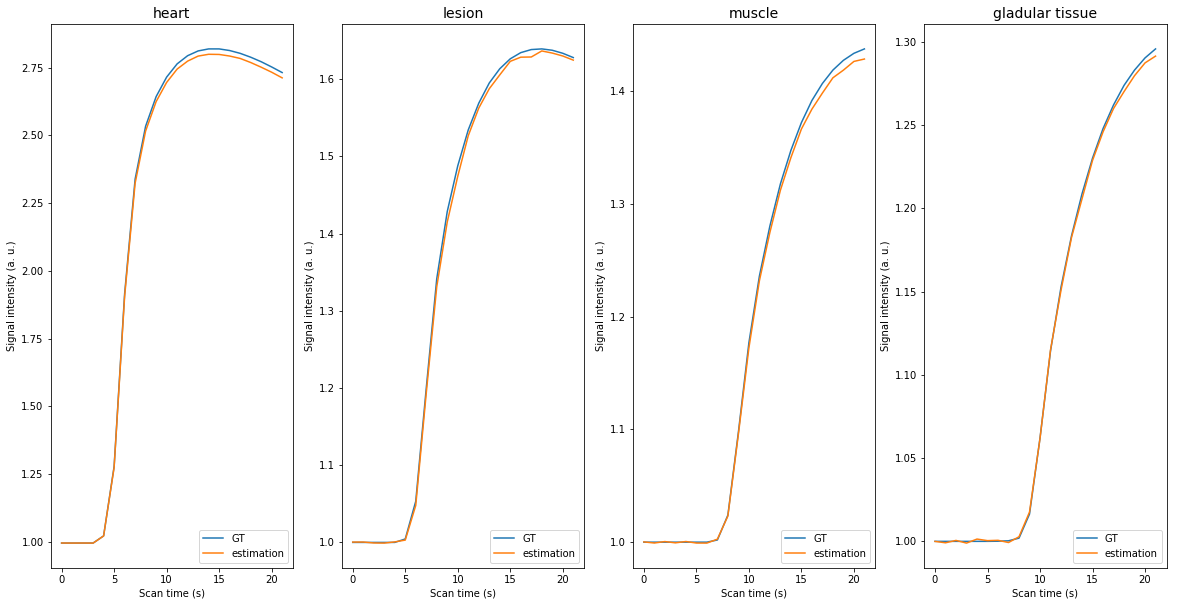

In [67]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

torch.Size([22, 2, 320, 320])


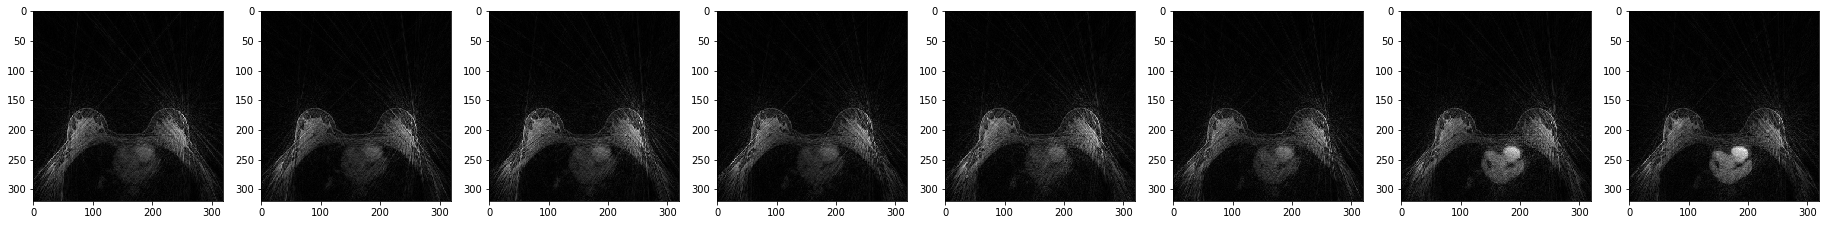

(22,)


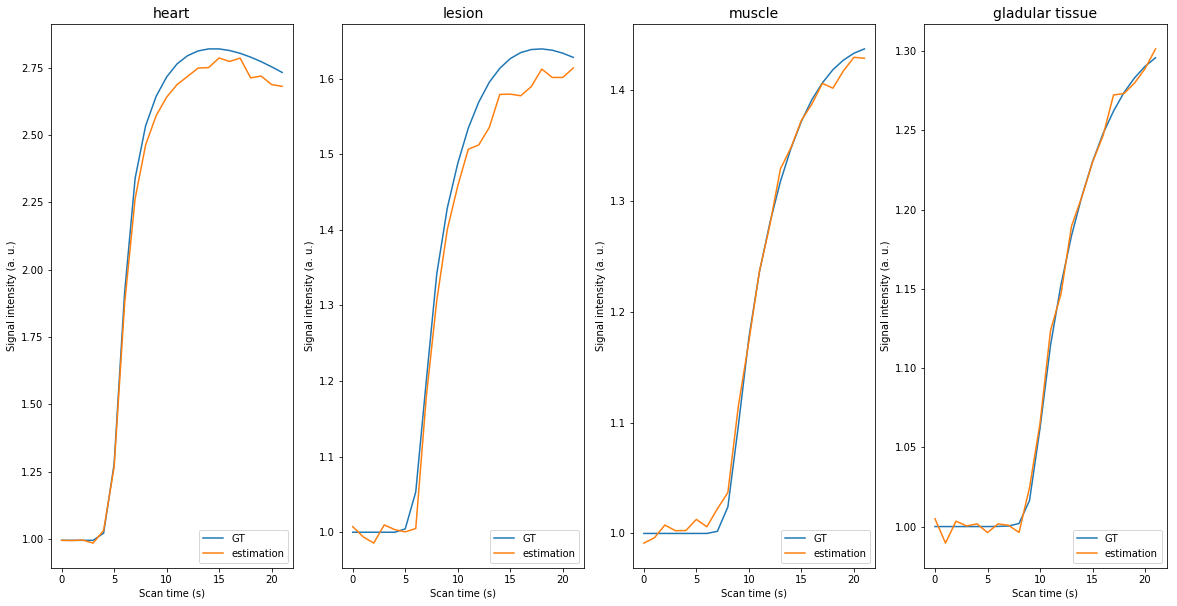

In [68]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Test with Malignant Case

dict_keys(['__header__', '__version__', '__globals__', 'ID', 'S0', 'aif', 'cts', 'mask', 'parMap', 'simImg', 'smap_complex'])


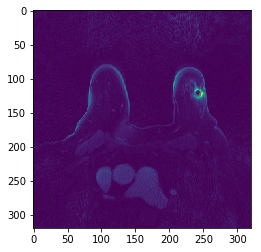

In [3]:
filedir = '/gpfs/home/zh1115/knolllabspace/hzn/storage/newsimulation/simulated_20210128/sim_BC33'
dataload = loadmat(filedir)
print(dataload.keys())

plt.imshow(np.abs(dataload['simImg'][:, :, 9]))
plt.show()

In [4]:
masksloaded = dataload['mask']

simulated_image = dataload['simImg']
simulated_image = np.flipud(np.array(simulated_image))#flip up and down

simulated_target = np.array(simulated_image, dtype='complex128')
simulated_target = simulated_target.swapaxes(0, 2).swapaxes(1, 2)
#print(simulated_target.shape, simulated_target.dtype)

target = np.stack((simulated_target.real, simulated_target.imag), axis=1)
target = torch.tensor(target, dtype=dtype, device=device)

smap_complex = dataload['smap_complex']
smap_loaded = numpy2torch(smap_complex, device =device)
smap_loaded = smap_loaded.permute(1,0,2,3).unsqueeze(0)

nt = 22
temporal_coilimg = np.array([sim_coil(simulated_target[i,:,:], smap_complex, coild=0) for i in range(nt)])

target_recombine= np.array([temporal_coilimg[:,i]*np.conj(smap_complex[i,:,:]) for i in range(temporal_coilimg.shape[1])])
target_recombine= np.sum(target_recombine, axis=0)

print("target.shape", target.shape, target.dtype,\
      "smap.shape", smap_loaded.shape, smap_loaded.dtype)

simulated_kspace_21, recon_fromsim_21, traj_21, dcomp_21 \
= RadialSimulation(target = target,
                   spokespertime=21,
                   nt=nt, nc=16,
                   spokelength=640,
                   smap=smap_loaded,
                   grid_size = (640, 640),
                   im_size= (320, 320))

recon_fromsim_21 = torch2numpy(recon_fromsim_21.permute(0,2,3,1))

target.shape torch.Size([22, 2, 320, 320]) torch.float32 smap.shape torch.Size([1, 16, 2, 320, 320]) torch.float32
torch.Size([22, 16, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


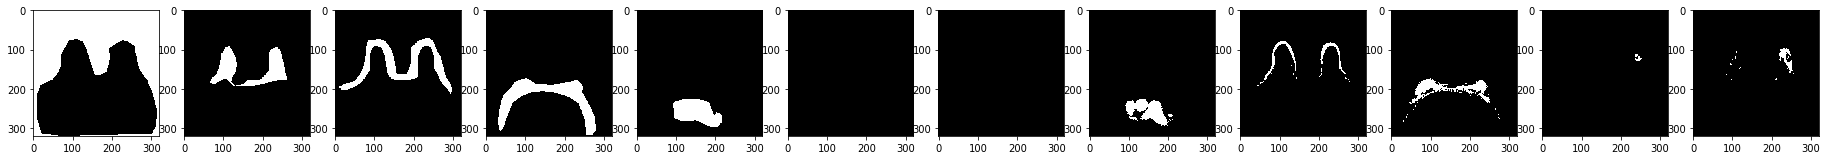

In [5]:
plotcoil(masksloaded[0][0], n = 12, cmap = 'gray')

In [6]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp

dcomp_FL = dcomp_reference(traj_21, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

torch.Size([22, 16, 2, 13440]) cpu


## Adjoint NUFFT, Updated Density Compensation

torch.Size([22, 2, 320, 320])


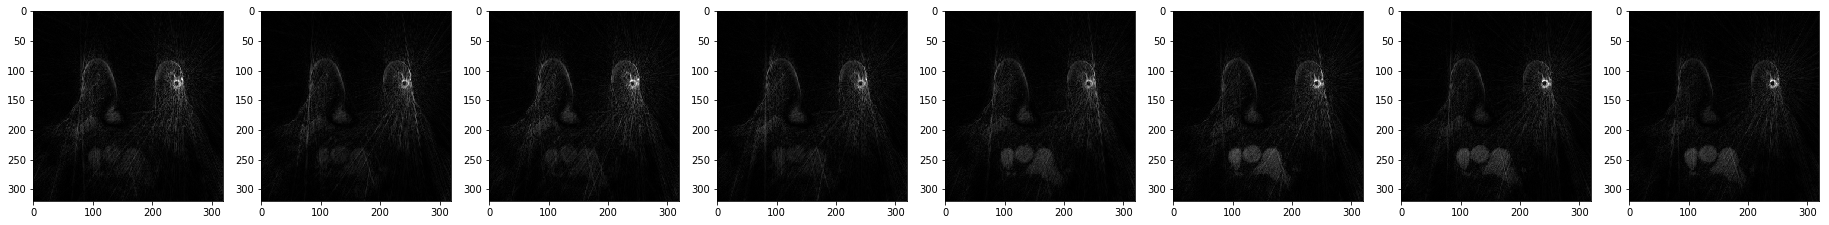

(22,)


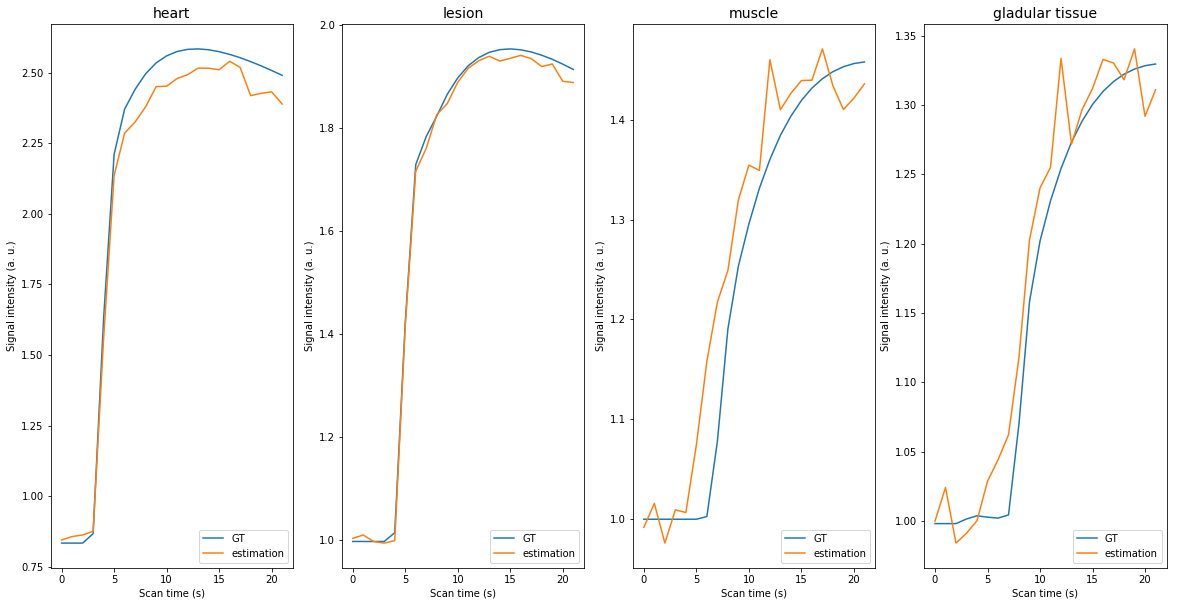

In [7]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## CG-SENSE, 128 steps

0 alpha:  tensor([2.7584e+01, 1.9091e-08], device='cuda:0')
1 alpha:  tensor([ 1.4356e+01, -8.8129e-08], device='cuda:0')
2 alpha:  tensor([ 1.1848e+01, -2.6770e-08], device='cuda:0')
3 alpha:  tensor([ 1.2794e+01, -4.3198e-08], device='cuda:0')
4 alpha:  tensor([ 1.4458e+01, -1.1813e-08], device='cuda:0')
5 alpha:  tensor([ 1.6325e+01, -2.2548e-08], device='cuda:0')
6 alpha:  tensor([ 1.6834e+01, -5.6160e-08], device='cuda:0')
7 alpha:  tensor([ 1.5825e+01, -4.5922e-08], device='cuda:0')
8 alpha:  tensor([1.5601e+01, 6.9480e-09], device='cuda:0')
9 alpha:  tensor([1.6448e+01, 6.8311e-09], device='cuda:0')
10 alpha:  tensor([ 1.7191e+01, -3.1032e-09], device='cuda:0')
11 alpha:  tensor([ 1.7007e+01, -2.1923e-08], device='cuda:0')
12 alpha:  tensor([ 1.6779e+01, -2.0682e-08], device='cuda:0')
13 alpha:  tensor([ 1.7408e+01, -1.1870e-08], device='cuda:0')
14 alpha:  tensor([18.4253, -0.0000], device='cuda:0')
15 alpha:  tensor([1.8624e+01, 1.8066e-08], device='cuda:0')
16 alpha:  tensor(

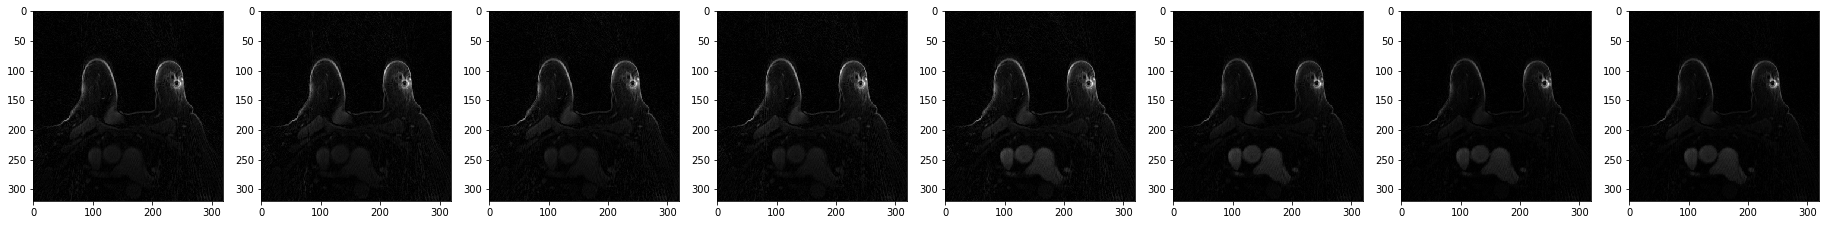

(22,)


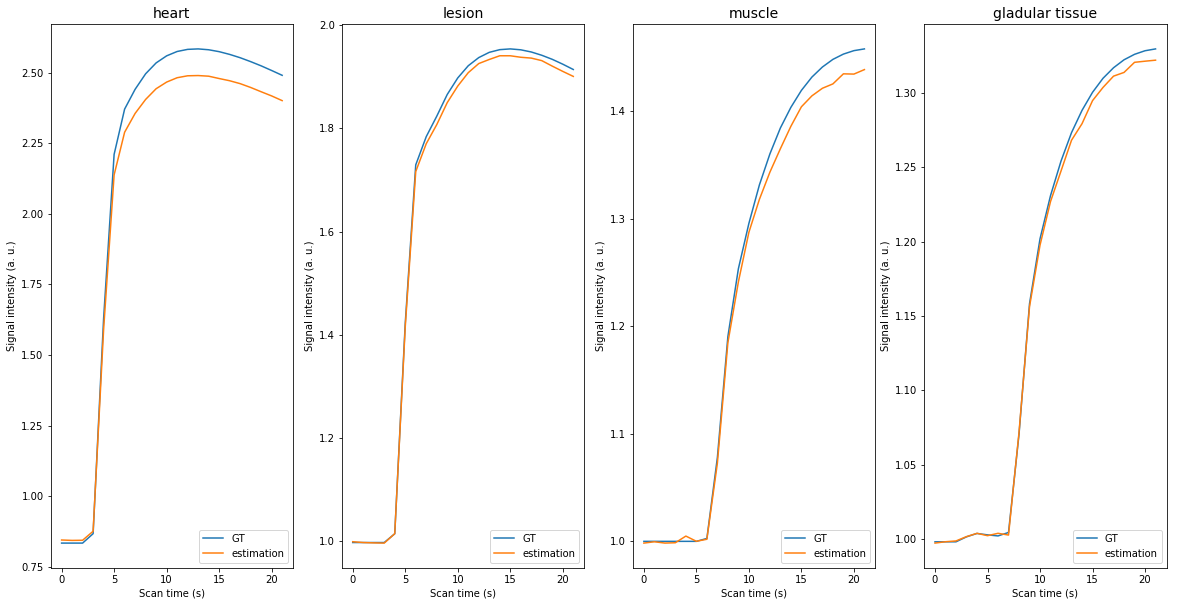

In [10]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## CG-SENSE, 640 steps

0 alpha:  tensor([2.7584e+01, 1.6119e-08], device='cuda:0')
1 alpha:  tensor([ 1.4356e+01, -8.7514e-08], device='cuda:0')
2 alpha:  tensor([ 1.1848e+01, -2.8304e-08], device='cuda:0')
3 alpha:  tensor([ 1.2794e+01, -3.6156e-08], device='cuda:0')
4 alpha:  tensor([ 1.4458e+01, -9.8445e-09], device='cuda:0')
5 alpha:  tensor([ 1.6325e+01, -2.2548e-08], device='cuda:0')
6 alpha:  tensor([ 1.6834e+01, -5.4093e-08], device='cuda:0')
7 alpha:  tensor([ 1.5825e+01, -4.2390e-08], device='cuda:0')
8 alpha:  tensor([1.5601e+01, 6.6006e-09], device='cuda:0')
9 alpha:  tensor([1.6448e+01, 2.4840e-09], device='cuda:0')
10 alpha:  tensor([1.7191e+01, 1.0026e-08], device='cuda:0')
11 alpha:  tensor([ 1.7007e+01, -1.3398e-08], device='cuda:0')
12 alpha:  tensor([ 1.6779e+01, -2.8513e-08], device='cuda:0')
13 alpha:  tensor([ 1.7408e+01, -5.9348e-09], device='cuda:0')
14 alpha:  tensor([ 1.8425e+01, -3.3786e-09], device='cuda:0')
15 alpha:  tensor([1.8624e+01, 1.0037e-08], device='cuda:0')
16 alpha:  t

131 alpha:  tensor([ 1.9277e+01, -1.6469e-08], device='cuda:0')
132 alpha:  tensor([ 1.9358e+01, -1.9157e-08], device='cuda:0')
133 alpha:  tensor([ 1.9127e+01, -4.2201e-09], device='cuda:0')
134 alpha:  tensor([ 1.9389e+01, -5.1595e-08], device='cuda:0')
135 alpha:  tensor([ 1.9396e+01, -2.6338e-08], device='cuda:0')
136 alpha:  tensor([ 1.9944e+01, -4.2773e-08], device='cuda:0')
137 alpha:  tensor([ 1.9714e+01, -5.0443e-09], device='cuda:0')
138 alpha:  tensor([ 1.9498e+01, -1.2474e-09], device='cuda:0')
139 alpha:  tensor([1.9614e+01, 2.5896e-08], device='cuda:0')
140 alpha:  tensor([ 1.9641e+01, -1.0667e-08], device='cuda:0')
141 alpha:  tensor([ 1.9396e+01, -5.2422e-09], device='cuda:0')
142 alpha:  tensor([1.9615e+01, 8.2890e-09], device='cuda:0')
143 alpha:  tensor([1.9363e+01, 1.0927e-08], device='cuda:0')
144 alpha:  tensor([ 1.9858e+01, -5.9059e-09], device='cuda:0')
145 alpha:  tensor([19.6557, -0.0000], device='cuda:0')
146 alpha:  tensor([ 1.9332e+01, -4.3832e-09], device=

262 alpha:  tensor([ 1.9775e+01, -4.7362e-08], device='cuda:0')
263 alpha:  tensor([1.9573e+01, 1.1705e-08], device='cuda:0')
264 alpha:  tensor([19.6976, -0.0000], device='cuda:0')
265 alpha:  tensor([1.9721e+01, 2.4308e-09], device='cuda:0')
266 alpha:  tensor([ 1.9527e+01, -9.6494e-09], device='cuda:0')
267 alpha:  tensor([ 1.9546e+01, -2.6801e-08], device='cuda:0')
268 alpha:  tensor([ 1.9547e+01, -9.8946e-09], device='cuda:0')
269 alpha:  tensor([1.9568e+01, 7.5041e-09], device='cuda:0')
270 alpha:  tensor([1.9500e+01, 3.5205e-08], device='cuda:0')
271 alpha:  tensor([ 1.9766e+01, -3.4279e-08], device='cuda:0')
272 alpha:  tensor([ 1.9461e+01, -3.3459e-08], device='cuda:0')
273 alpha:  tensor([19.5173, -0.0000], device='cuda:0')
274 alpha:  tensor([1.9498e+01, 5.2861e-09], device='cuda:0')
275 alpha:  tensor([ 1.9393e+01, -1.0601e-08], device='cuda:0')
276 alpha:  tensor([ 1.9343e+01, -3.1819e-08], device='cuda:0')
277 alpha:  tensor([1.9873e+01, 5.4377e-08], device='cuda:0')
278 

394 alpha:  tensor([1.9678e+01, 1.7495e-08], device='cuda:0')
395 alpha:  tensor([19.7334, -0.0000], device='cuda:0')
396 alpha:  tensor([1.9677e+01, 8.8727e-09], device='cuda:0')
397 alpha:  tensor([ 1.9939e+01, -1.8512e-08], device='cuda:0')
398 alpha:  tensor([1.9827e+01, 3.6863e-08], device='cuda:0')
399 alpha:  tensor([ 1.9609e+01, -1.3514e-08], device='cuda:0')
400 alpha:  tensor([ 1.9444e+01, -6.6786e-09], device='cuda:0')
401 alpha:  tensor([ 1.9534e+01, -3.6355e-08], device='cuda:0')
402 alpha:  tensor([ 1.9442e+01, -3.6208e-08], device='cuda:0')
403 alpha:  tensor([ 1.9402e+01, -1.8180e-08], device='cuda:0')
404 alpha:  tensor([1.9652e+01, 2.8352e-08], device='cuda:0')
405 alpha:  tensor([ 1.9697e+01, -1.9196e-08], device='cuda:0')
406 alpha:  tensor([ 1.9892e+01, -3.9551e-08], device='cuda:0')
407 alpha:  tensor([ 1.9802e+01, -4.2115e-08], device='cuda:0')
408 alpha:  tensor([1.9749e+01, 5.9227e-08], device='cuda:0')
409 alpha:  tensor([ 1.9761e+01, -5.4961e-08], device='cud

525 alpha:  tensor([ 1.9737e+01, -1.1642e-08], device='cuda:0')
526 alpha:  tensor([ 1.9564e+01, -5.1218e-08], device='cuda:0')
527 alpha:  tensor([1.9886e+01, 2.3990e-08], device='cuda:0')
528 alpha:  tensor([ 1.9615e+01, -7.0414e-08], device='cuda:0')
529 alpha:  tensor([ 1.9562e+01, -3.4945e-08], device='cuda:0')
530 alpha:  tensor([ 1.9476e+01, -2.9074e-08], device='cuda:0')
531 alpha:  tensor([1.9858e+01, 1.2306e-08], device='cuda:0')
532 alpha:  tensor([19.8199, -0.0000], device='cuda:0')
533 alpha:  tensor([ 1.9867e+01, -4.9801e-08], device='cuda:0')
534 alpha:  tensor([ 1.9770e+01, -1.5466e-08], device='cuda:0')
535 alpha:  tensor([1.9980e+01, 2.5513e-08], device='cuda:0')
536 alpha:  tensor([1.9736e+01, 2.4981e-08], device='cuda:0')
537 alpha:  tensor([1.9394e+01, 6.0167e-09], device='cuda:0')
538 alpha:  tensor([ 1.9799e+01, -3.8132e-08], device='cuda:0')
539 alpha:  tensor([1.9876e+01, 5.1668e-08], device='cuda:0')
540 alpha:  tensor([ 1.9714e+01, -1.2789e-08], device='cuda:

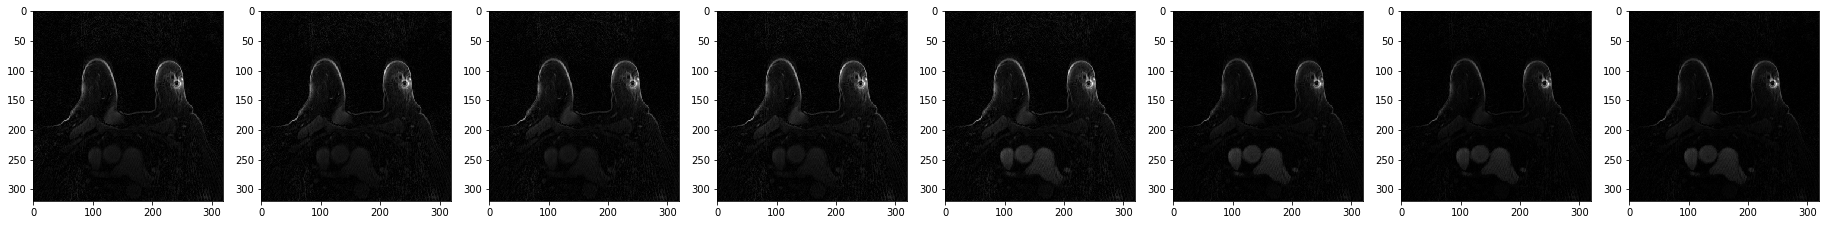

(22,)


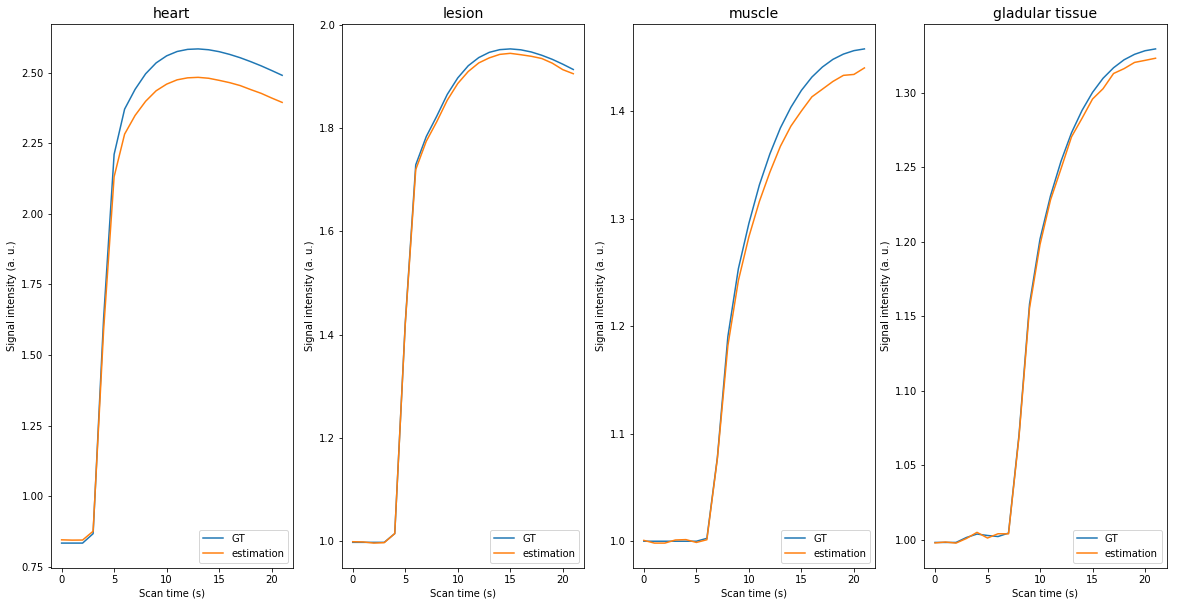

In [13]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Original Density Compensation

torch.Size([22, 2, 320, 320])


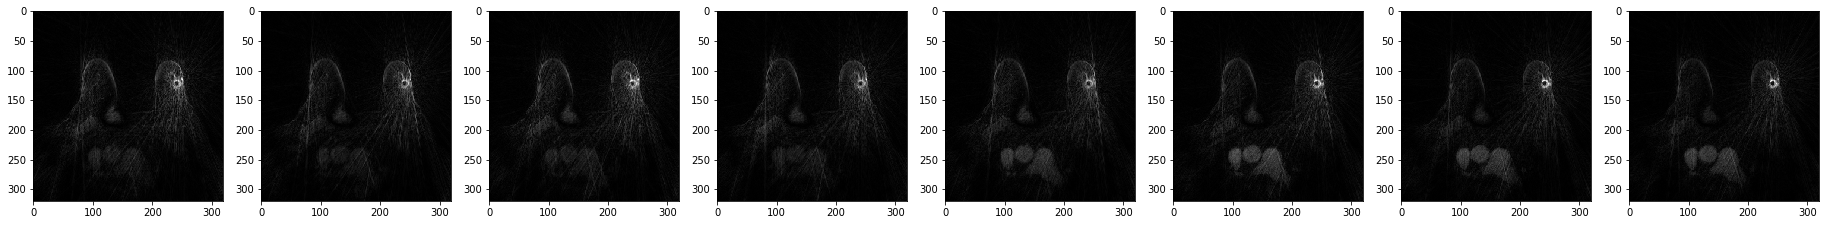

(22,)


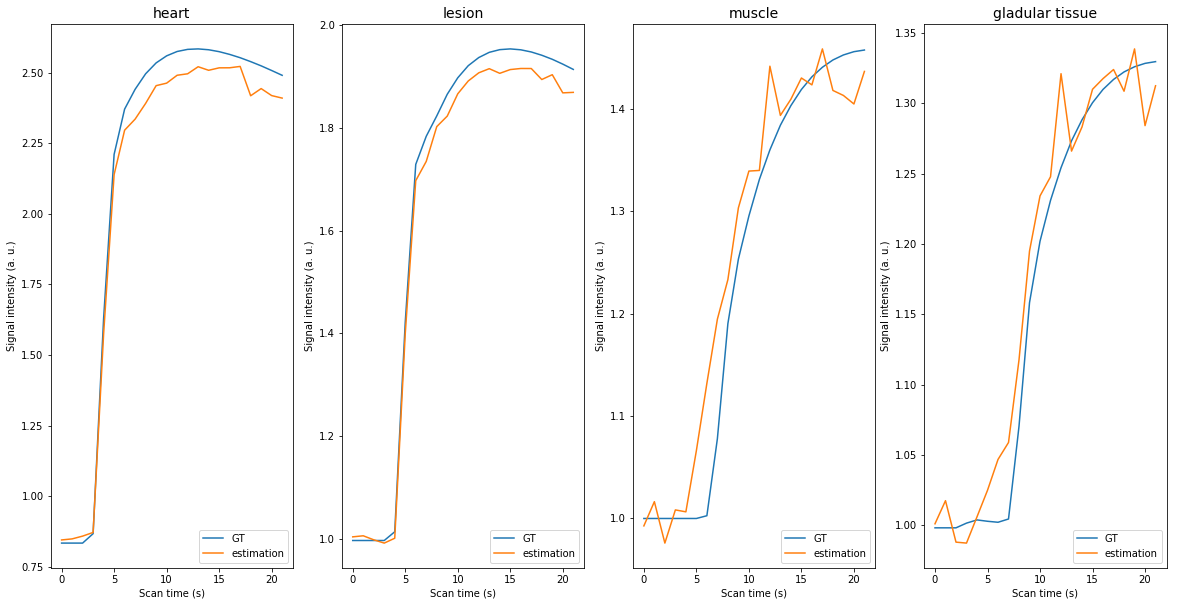

In [61]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_21.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 2.8689e+01, -1.0758e-07], device='cuda:0')
1 alpha:  tensor([ 1.3125e+01, -9.6832e-08], device='cuda:0')
2 alpha:  tensor([ 1.1449e+01, -2.1629e-08], device='cuda:0')
3 alpha:  tensor([ 1.3289e+01, -2.9417e-08], device='cuda:0')
4 alpha:  tensor([ 1.5600e+01, -2.0044e-08], device='cuda:0')
5 alpha:  tensor([ 1.6550e+01, -5.7089e-08], device='cuda:0')
6 alpha:  tensor([ 1.5753e+01, -6.3215e-08], device='cuda:0')
7 alpha:  tensor([ 1.5213e+01, -3.3553e-08], device='cuda:0')
8 alpha:  tensor([1.6268e+01, 2.2988e-08], device='cuda:0')
9 alpha:  tensor([ 1.7455e+01, -4.9107e-09], device='cuda:0')
10 alpha:  tensor([ 1.6945e+01, -4.3822e-08], device='cuda:0')
11 alpha:  tensor([ 1.6056e+01, -3.8481e-08], device='cuda:0')
12 alpha:  tensor([ 1.6719e+01, -4.3534e-09], device='cuda:0')
13 alpha:  tensor([ 1.8549e+01, -1.4131e-09], device='cuda:0')
14 alpha:  tensor([ 1.9054e+01, -6.6447e-09], device='cuda:0')
15 alpha:  tensor([ 1.7678e+01, -8.1310e-09], device='cuda:0')
16 a

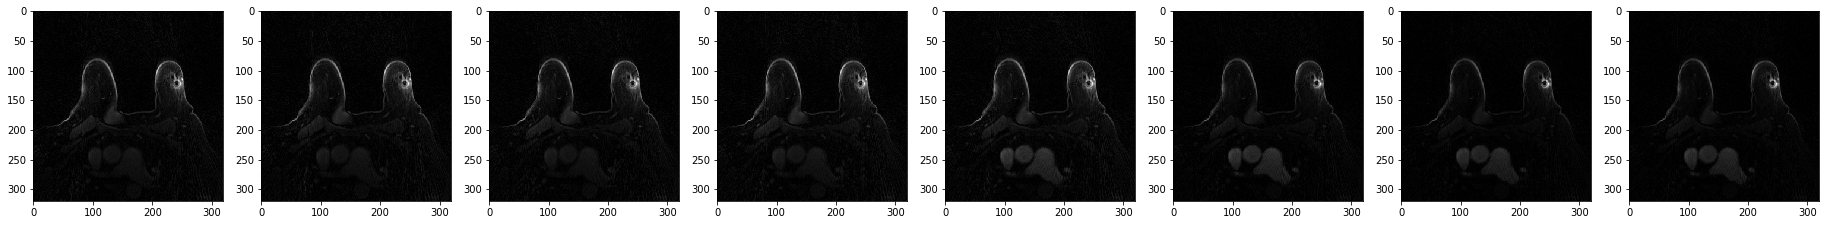

(22,)


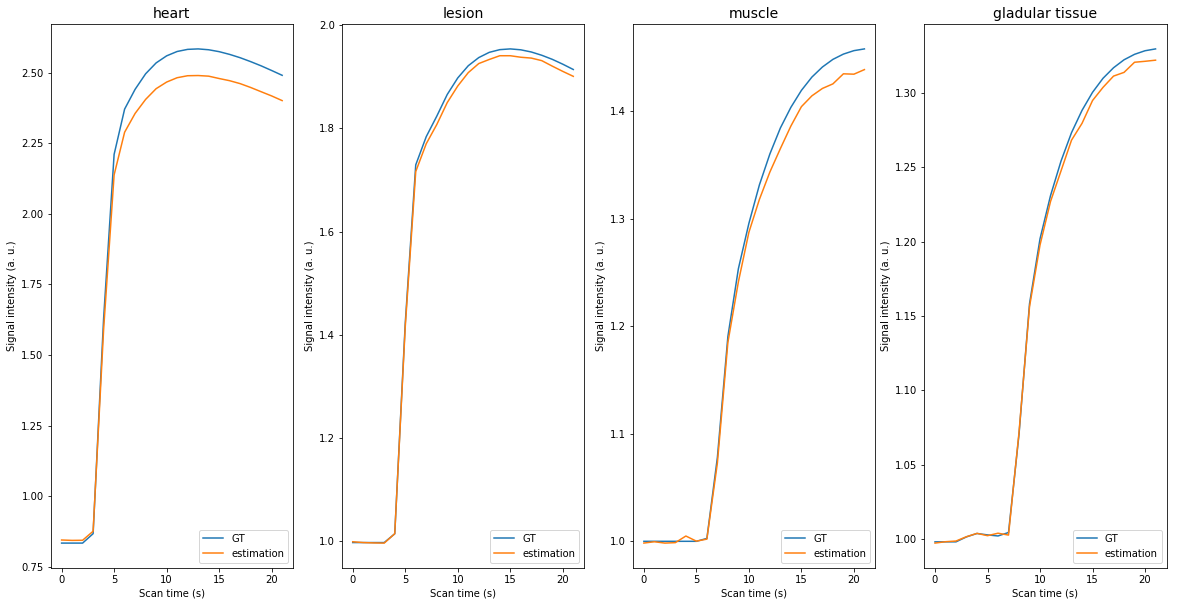

In [11]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 2.8689e+01, -1.0451e-07], device='cuda:0')
1 alpha:  tensor([ 1.3125e+01, -9.3826e-08], device='cuda:0')
2 alpha:  tensor([ 1.1449e+01, -2.5264e-08], device='cuda:0')
3 alpha:  tensor([ 1.3289e+01, -2.7081e-08], device='cuda:0')
4 alpha:  tensor([ 1.5600e+01, -2.0521e-08], device='cuda:0')
5 alpha:  tensor([ 1.6550e+01, -5.2505e-08], device='cuda:0')
6 alpha:  tensor([ 1.5753e+01, -5.7901e-08], device='cuda:0')
7 alpha:  tensor([ 1.5213e+01, -3.2670e-08], device='cuda:0')
8 alpha:  tensor([1.6268e+01, 3.0225e-08], device='cuda:0')
9 alpha:  tensor([1.7455e+01, 4.2091e-09], device='cuda:0')
10 alpha:  tensor([ 1.6945e+01, -5.6161e-08], device='cuda:0')
11 alpha:  tensor([ 1.6056e+01, -2.1378e-08], device='cuda:0')
12 alpha:  tensor([ 1.6719e+01, -1.5890e-08], device='cuda:0')
13 alpha:  tensor([ 1.8549e+01, -2.1197e-09], device='cuda:0')
14 alpha:  tensor([ 1.9054e+01, -1.6612e-08], device='cuda:0')
15 alpha:  tensor([ 1.7678e+01, -6.9114e-09], device='cuda:0')
16 alp

131 alpha:  tensor([ 1.9115e+01, -1.5974e-08], device='cuda:0')
132 alpha:  tensor([ 1.9395e+01, -3.2366e-08], device='cuda:0')
133 alpha:  tensor([1.9523e+01, 9.0208e-09], device='cuda:0')
134 alpha:  tensor([ 1.9699e+01, -4.6781e-09], device='cuda:0')
135 alpha:  tensor([ 1.9290e+01, -2.0131e-08], device='cuda:0')
136 alpha:  tensor([ 1.9440e+01, -4.8431e-08], device='cuda:0')
137 alpha:  tensor([ 1.9321e+01, -9.7008e-09], device='cuda:0')
138 alpha:  tensor([1.9731e+01, 1.8197e-08], device='cuda:0')
139 alpha:  tensor([ 1.9737e+01, -2.6175e-09], device='cuda:0')
140 alpha:  tensor([1.9404e+01, 1.7836e-08], device='cuda:0')
141 alpha:  tensor([ 1.9299e+01, -2.5951e-08], device='cuda:0')
142 alpha:  tensor([ 1.9469e+01, -4.2794e-08], device='cuda:0')
143 alpha:  tensor([ 1.9494e+01, -2.7965e-09], device='cuda:0')
144 alpha:  tensor([ 1.9760e+01, -1.1571e-08], device='cuda:0')
145 alpha:  tensor([1.9306e+01, 3.3622e-08], device='cuda:0')
146 alpha:  tensor([ 1.9350e+01, -1.1712e-08], d

261 alpha:  tensor([ 1.9866e+01, -4.7414e-09], device='cuda:0')
262 alpha:  tensor([1.9962e+01, 7.2613e-09], device='cuda:0')
263 alpha:  tensor([ 1.9866e+01, -7.2853e-09], device='cuda:0')
264 alpha:  tensor([ 1.9751e+01, -2.9066e-08], device='cuda:0')
265 alpha:  tensor([ 1.9577e+01, -3.8385e-08], device='cuda:0')
266 alpha:  tensor([ 1.9753e+01, -4.2252e-08], device='cuda:0')
267 alpha:  tensor([ 1.9733e+01, -3.7487e-09], device='cuda:0')
268 alpha:  tensor([ 1.9488e+01, -5.3990e-08], device='cuda:0')
269 alpha:  tensor([1.9641e+01, 2.0237e-08], device='cuda:0')
270 alpha:  tensor([ 1.9633e+01, -1.5449e-08], device='cuda:0')
271 alpha:  tensor([ 1.9808e+01, -2.6543e-08], device='cuda:0')
272 alpha:  tensor([ 1.9480e+01, -5.6591e-08], device='cuda:0')
273 alpha:  tensor([ 1.9333e+01, -2.5588e-08], device='cuda:0')
274 alpha:  tensor([1.9552e+01, 1.0639e-08], device='cuda:0')
275 alpha:  tensor([ 1.9581e+01, -4.8874e-08], device='cuda:0')
276 alpha:  tensor([1.9660e+01, 2.2195e-08], d

392 alpha:  tensor([1.9529e+01, 4.6608e-08], device='cuda:0')
393 alpha:  tensor([ 1.9420e+01, -6.7308e-08], device='cuda:0')
394 alpha:  tensor([1.9485e+01, 3.6193e-08], device='cuda:0')
395 alpha:  tensor([1.9674e+01, 1.7645e-08], device='cuda:0')
396 alpha:  tensor([ 1.9653e+01, -3.5373e-08], device='cuda:0')
397 alpha:  tensor([1.9726e+01, 9.0051e-09], device='cuda:0')
398 alpha:  tensor([1.9751e+01, 9.1227e-09], device='cuda:0')
399 alpha:  tensor([19.5991, -0.0000], device='cuda:0')
400 alpha:  tensor([1.9534e+01, 1.2404e-08], device='cuda:0')
401 alpha:  tensor([1.9871e+01, 2.3621e-09], device='cuda:0')
402 alpha:  tensor([ 1.9733e+01, -3.6560e-08], device='cuda:0')
403 alpha:  tensor([1.9802e+01, 9.5894e-09], device='cuda:0')
404 alpha:  tensor([ 1.9930e+01, -4.9133e-09], device='cuda:0')
405 alpha:  tensor([1.9752e+01, 3.8718e-08], device='cuda:0')
406 alpha:  tensor([1.9789e+01, 3.4201e-08], device='cuda:0')
407 alpha:  tensor([ 1.9874e+01, -1.9971e-08], device='cuda:0')
408 

524 alpha:  tensor([1.9723e+01, 3.7462e-08], device='cuda:0')
525 alpha:  tensor([1.9678e+01, 2.3071e-08], device='cuda:0')
526 alpha:  tensor([ 1.9405e+01, -6.7405e-08], device='cuda:0')
527 alpha:  tensor([ 1.9346e+01, -2.7961e-08], device='cuda:0')
528 alpha:  tensor([ 1.9386e+01, -4.5212e-08], device='cuda:0')
529 alpha:  tensor([1.9508e+01, 4.0506e-08], device='cuda:0')
530 alpha:  tensor([ 1.9706e+01, -1.1993e-08], device='cuda:0')
531 alpha:  tensor([1.9722e+01, 6.0424e-09], device='cuda:0')
532 alpha:  tensor([ 1.9892e+01, -9.3010e-09], device='cuda:0')
533 alpha:  tensor([1.9641e+01, 2.1179e-08], device='cuda:0')
534 alpha:  tensor([1.9763e+01, 3.0966e-09], device='cuda:0')
535 alpha:  tensor([ 1.9737e+01, -9.2912e-09], device='cuda:0')
536 alpha:  tensor([ 1.9871e+01, -6.3451e-09], device='cuda:0')
537 alpha:  tensor([ 1.9805e+01, -9.5148e-09], device='cuda:0')
538 alpha:  tensor([1.9704e+01, 1.7363e-08], device='cuda:0')
539 alpha:  tensor([1.9564e+01, 1.8672e-08], device='c

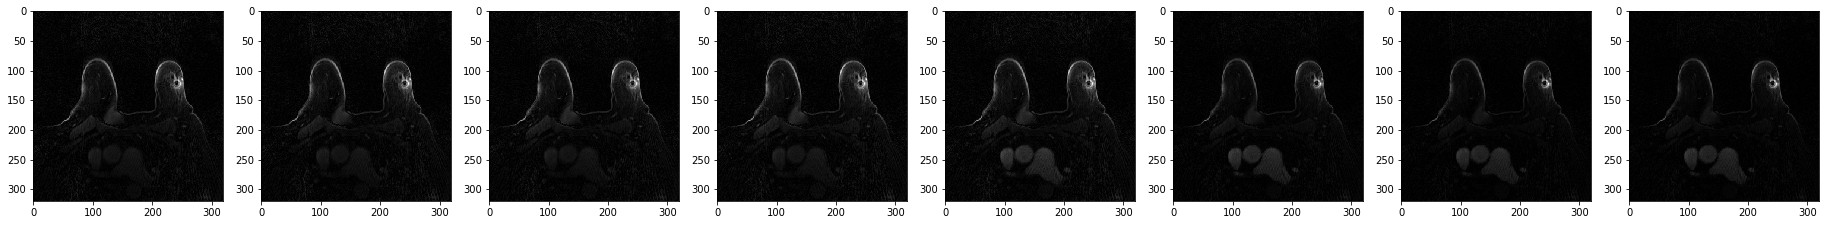

(22,)


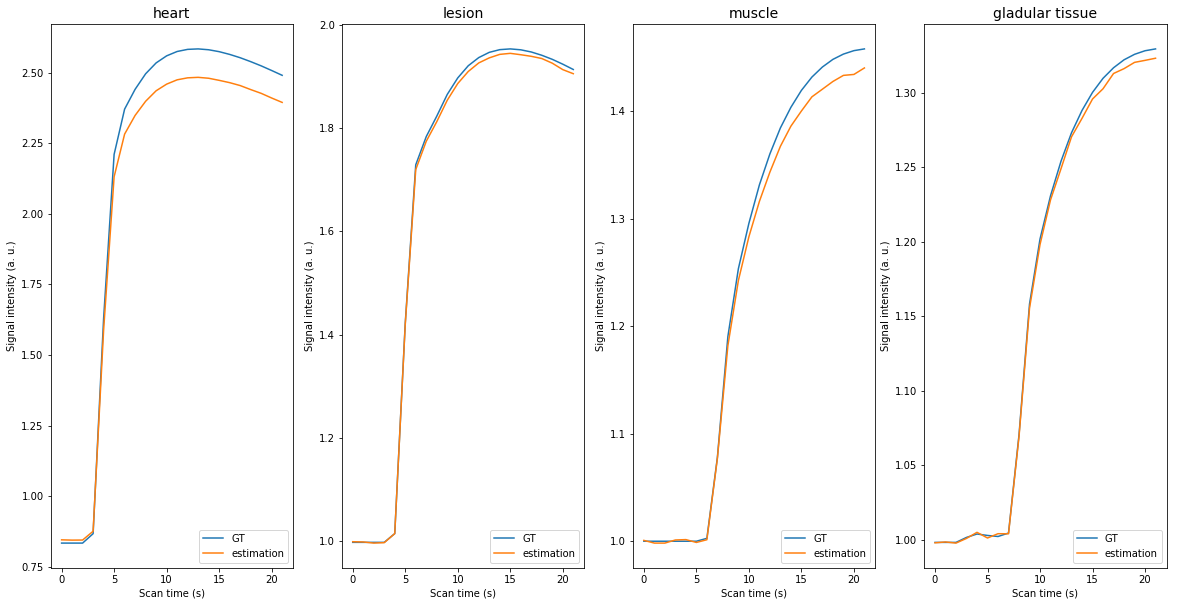

In [12]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

# Control: Cartesian Simulation and Reconstruction

In [8]:
simulated_kspace_cartesian, recon_fromsim_cartesian = CartesianSimulation(target = target, smap=smap_loaded)

recon_fromsim_cartesian = torch2numpy(recon_fromsim_cartesian.squeeze().permute(0,2,3,1))

torch.Size([16, 22, 320, 320, 2])
y.shape torch.Size([16, 22, 320, 320, 2])
cimage.shape torch.Size([16, 22, 320, 320, 2])
cimage.shape torch.Size([22, 16, 2, 320, 320])
torch.Size([22, 1, 2, 320, 320])


In [9]:
simulated_kspace_cartesian.shape, recon_fromsim_cartesian.shape

(torch.Size([16, 22, 320, 320, 2]), (22, 320, 320))

In [10]:
smap_loaded.shape

torch.Size([1, 16, 2, 320, 320])

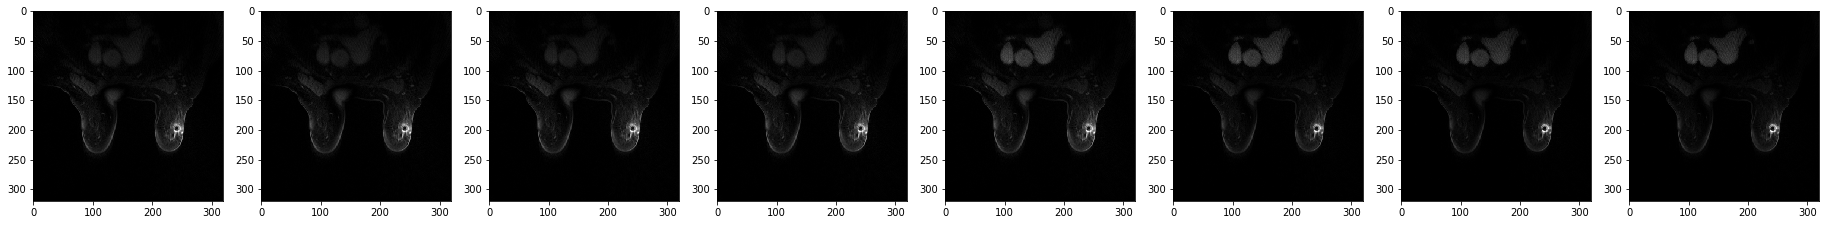

In [11]:
plotcoil(x = np.abs(recon_fromsim_cartesian))

In [12]:
target_numpy = torch2numpy(target, complexdim= 1)

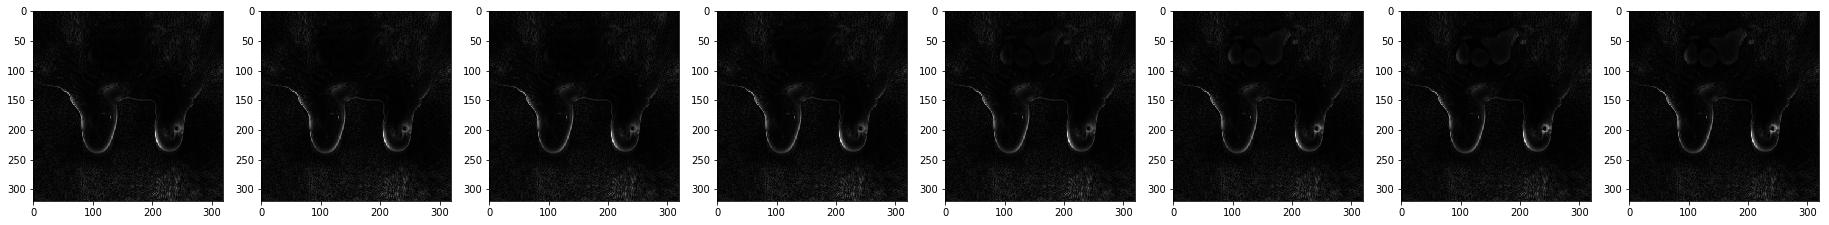

In [13]:
plotcoil(x = np.abs(recon_fromsim_cartesian - target_numpy))

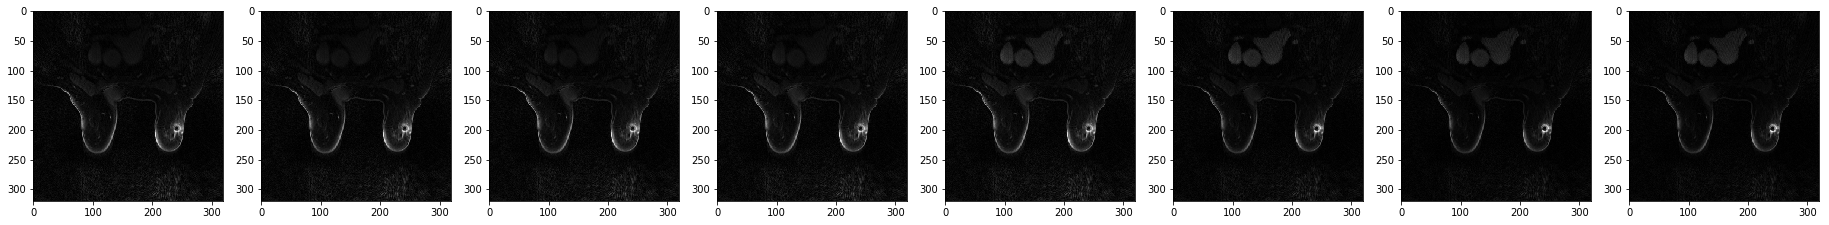

In [14]:
plotcoil(x = np.abs(target_numpy))

(22,)


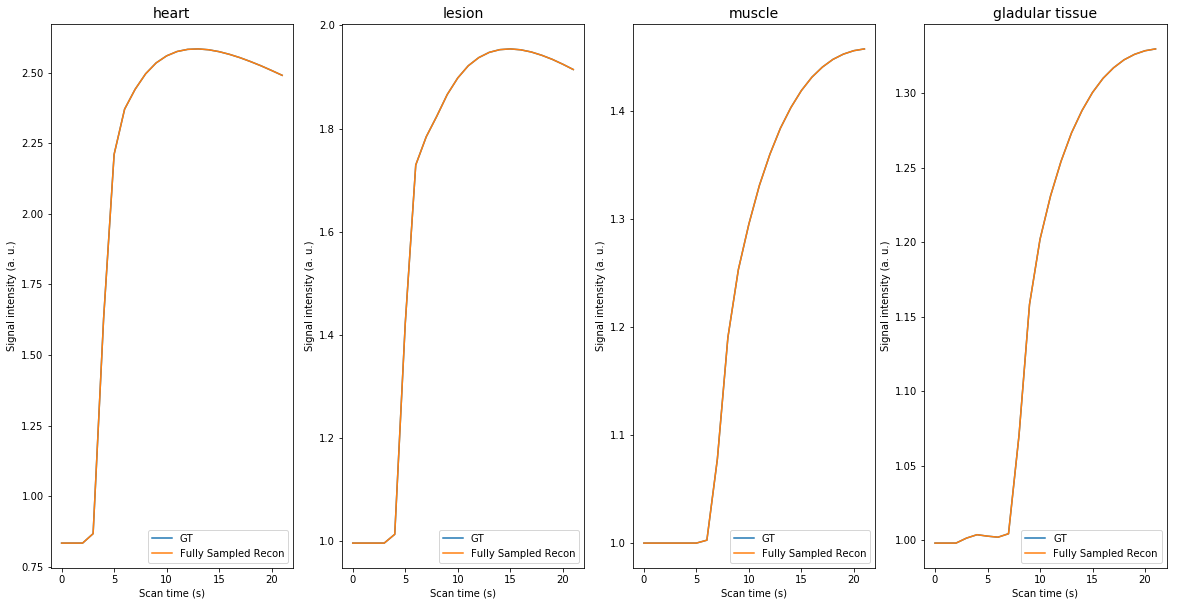

In [15]:
plotcurves(x_hat = np.abs(recon_fromsim_cartesian[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           #x_gt = target_numpy, 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

(22,)


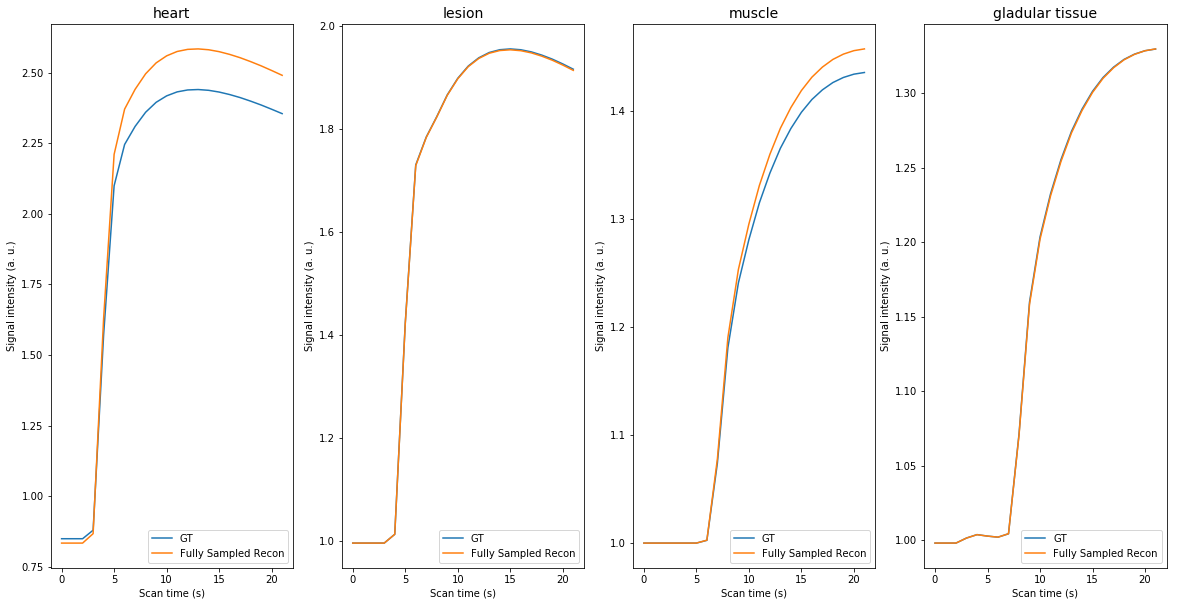

In [16]:
plotcurves(x_hat = np.abs(recon_fromsim_cartesian[:,::-1,:]), 
           #x_gt = target_recombine, #[:,::-1,:], 
           x_gt = np.abs(target_numpy[:,::-1,:]), 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

In [45]:
def mask_undersample(imsize, centerlines, rate, ifshift = True):
    assert len(imsize) == 2
    assert imsize[0] % 2 == 0 and imsize[1] % 2 == 0 and centerlines % 2 == 0
    
    res = torch.zeros(imsize)
    res[::rate] = 1
    res[imsize[0] // 2 - centerlines // 2 : imsize[1] // 2 + centerlines // 2] = 1
    
    if ifshift:
        res = torch.flip(res, dims = (0, 1))
    
    return res

In [72]:
cartesian_usmask = mask_undersample((320, 320), 16, 4, True)
cartesian_usmask = torch.tensor(np.fft.fftshift(cartesian_usmask.cpu().numpy(), axes = (0, 1))).to(device)

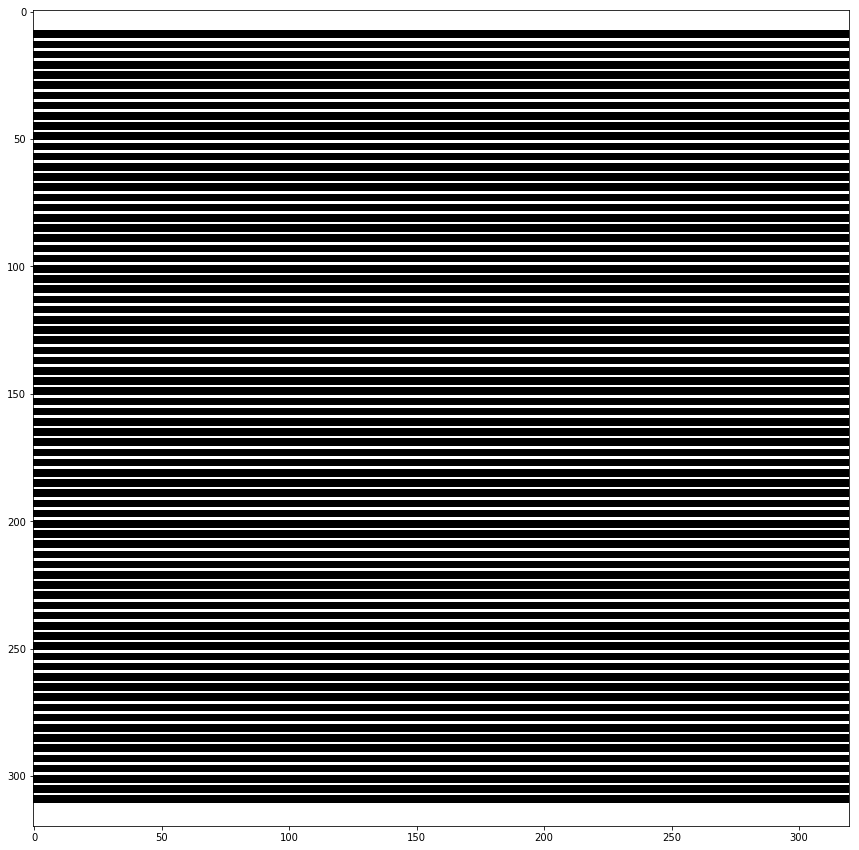

In [75]:
cartesian_usmask.shape
plt.figure(figsize = (15, 15))
plt.imshow(cartesian_usmask.cpu())
plt.show()

In [76]:
cartesian_usmask.reshape((1, 1, 320, 320, 1)).shape

torch.Size([1, 1, 320, 320, 1])

In [77]:
simulated_kspace_cartesian_4x = simulated_kspace_cartesian * cartesian_usmask.reshape((1, 1, 320, 320, 1)).to(device)
print(simulated_kspace_cartesian_4x.shape)

torch.Size([16, 22, 320, 320, 2])


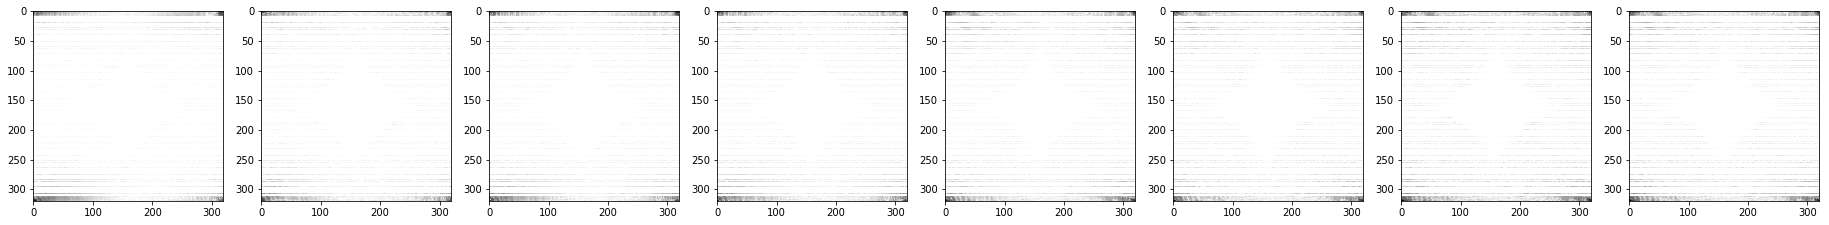

In [78]:
plotcoil(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_4x)[:, 0])))

In [59]:
np.log(torch2numpy(simulated_kspace_cartesian_4x)[0, 0]).shape

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(320, 320)

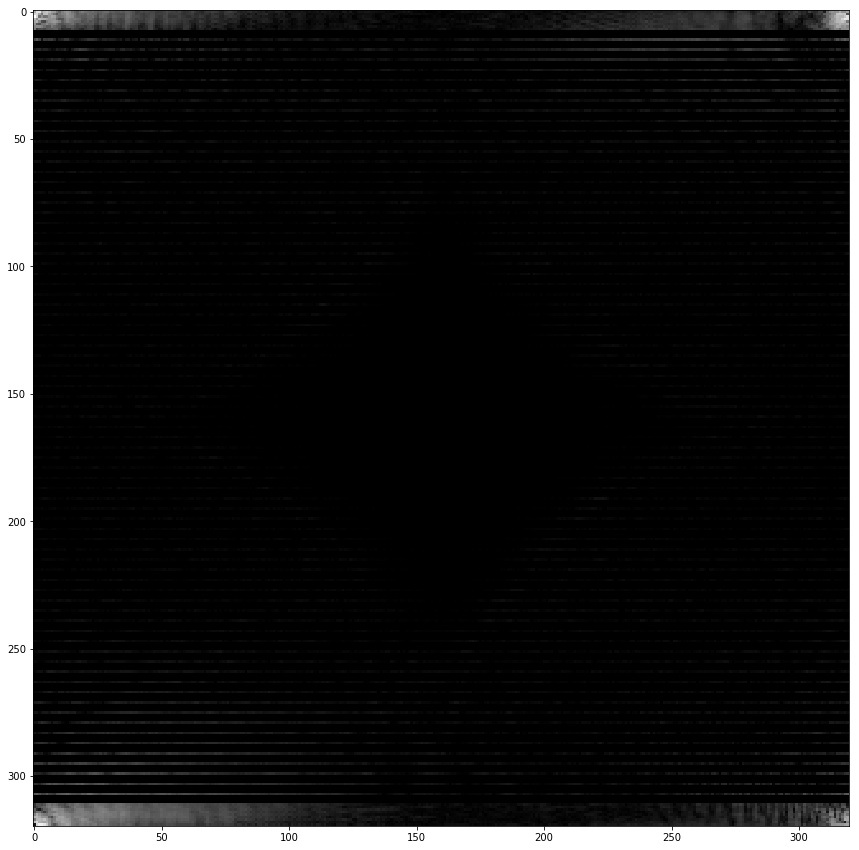

In [79]:
plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian_4x)[0, 0])))
plt.show()

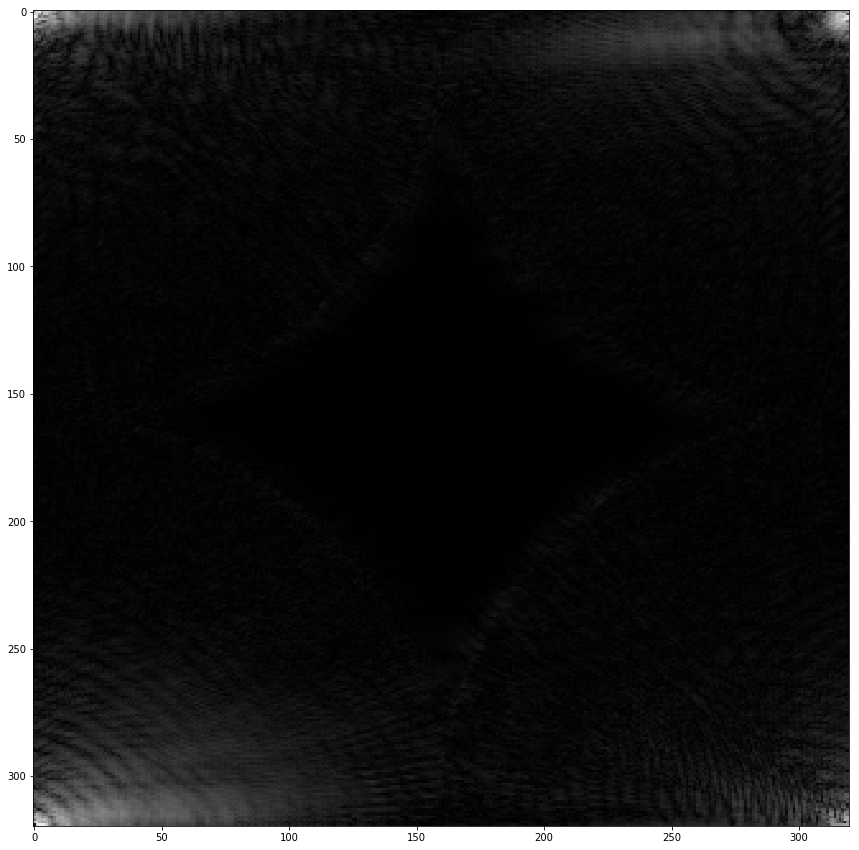

In [80]:
plt.figure(figsize=(15, 15))
plt.imshow(np.log(0.00001 + np.abs(torch2numpy(simulated_kspace_cartesian)[0, 0])))
plt.show()

y.shape torch.Size([16, 22, 320, 320, 2])
cimage.shape torch.Size([16, 22, 320, 320, 2])
cimage.shape torch.Size([22, 16, 2, 320, 320])


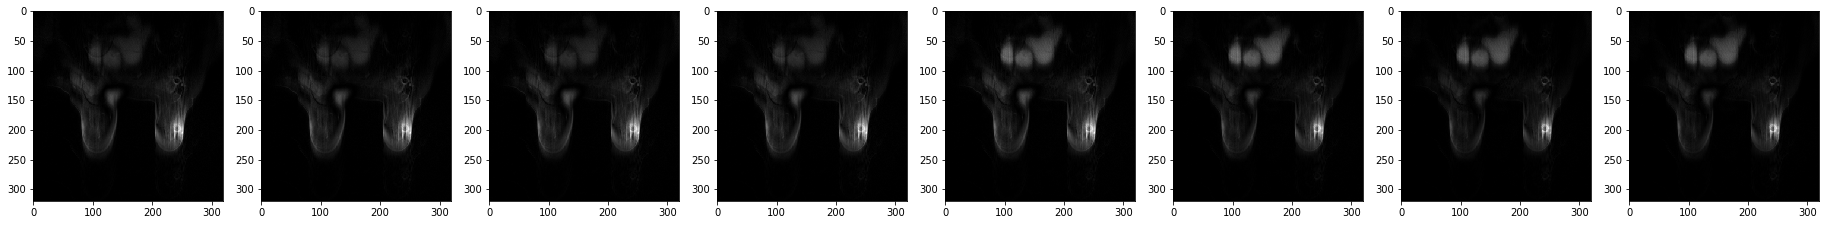

(22, 320, 320)


In [87]:
Cartesian_model = CartesianModel()

zerofilled = Cartesian_model.backward(y = simulated_kspace_cartesian_4x, coil_sensitivities= smap_loaded)

zerofilled = torch2numpy(zerofilled.squeeze(), complexdim=1)

plotcoil(zerofilled)

print(zerofilled.shape)

(22,)


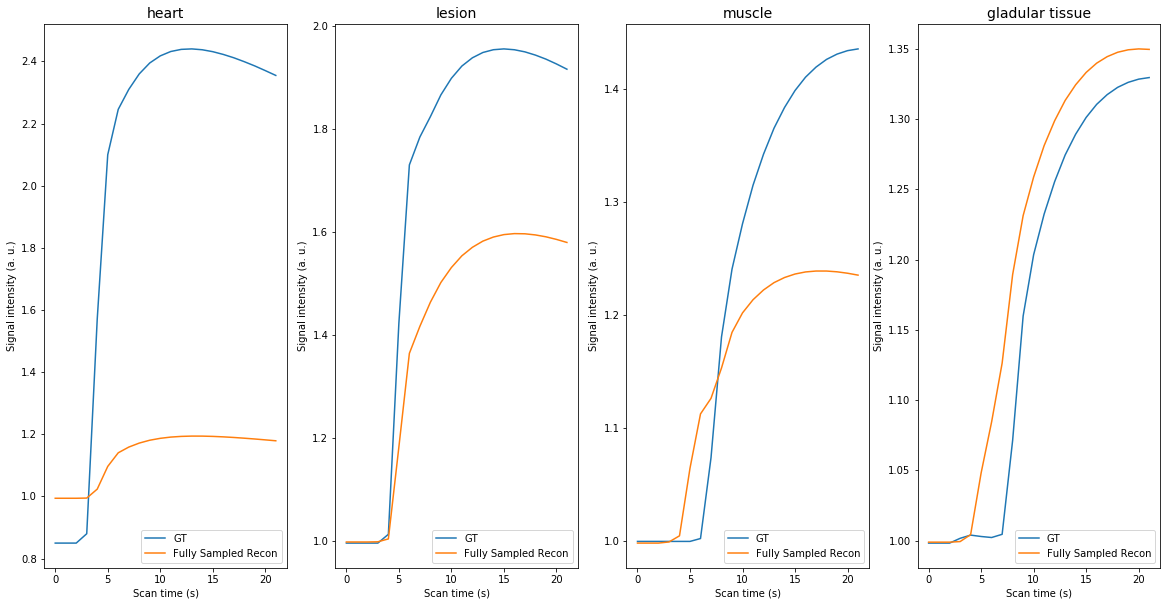

In [154]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Fully Sampled Recon', 'GT'], 
           normalize = True)

In [141]:
def CartesianRecon(kspace, coil_sensitivities, w, tolerance = 0.001,
                   lambda1 = None, lambda2 = None, device=device,
                   dtype=dtype, keep_history = False, niter=12,
                   optimizer = 'GD', stepsize = None):
    """
    Radial kspace reconstruction.
    tolerance is used to determine stop condition. It is to be tuned,
    original setting was 0.01, however 0.001 seems to give a better
    curve(R=2) Implementing CG according to
    https://dl.acm.org/doi/pdf/10.1145/3180496.3180632
    Returns:
        reconstruction, NUFFT recon, history(if keep_history = True)
    """

    model = CartesianModel()
    model = model.to(device, dtype)

    initial_recon = model.backward(kspace, coil_sensitivities)
    
    #------------Radial specific------------
    
    #print('initial_recon.shape', initial_recon.shape)
    output = model.forward(initial_recon, coil_sensitivities)
    target = kspace
    scalar = (output*target).sum()/(output**2).sum()
    x0 = (scalar.detach()*initial_recon).requires_grad_(True)
    initial_recon = x0.cpu().detach().numpy().copy()

    history = []

    #------------optimization----------------
    if stepsize is None:
        stepsize = [0.5]*15+[0.05]*niter
    if optimizer == 'GD':
        x0 = model.backward(kspace, coil_sensitivities)
        #print('x0.shape', x0.shape)
        #print('w.shape', w.shape)
        with torch.no_grad():
            for i in range(niter):
                output = model.forward(x0, coil_sensitivities) * w
                
                #print('output.shape', output.shape)
                residual = (output - kspace)
                #print(i, 'Residual l2 norm ={:f}'.format(torch.norm(residual)))
                x0 = x0 - stepsize[i] * model.backward(residual, coil_sensitivities)
                history.append(x0.detach().cpu().numpy())
    elif optimizer == 'CG5':
        EH_b = model.backward(kspace, coil_sensitivities)
        x0 = torch.zeros(EH_b.shape).to(device)
        r = EH_b.detach().clone()
        p = EH_b.detach().clone()
        with torch.no_grad():
            for i in range(niter):
                rHr = torch.norm(r)**2
                E_p = model.forward(p, coil_sensitivities) * w
                q = model.backward(E_p, coil_sensitivities) # E^H E p

                pHq = torch.sum(cpo.multiplication_conjugate(q, p, dim=1), dim =(0, 2, 3))
                pHqconj = pHq.detach().clone()
                pHqconj[1] = -pHqconj[1]
                #print(pHq, pHqconj)
                oneoverpHq = pHqconj/(torch.norm(pHq)**2)
                #print('phq.shape', pHq.shape)
                #print('oneoverpHp.shape', oneoverpHp.shape)
                alpha = rHr * oneoverpHq
                print(i, 'alpha: ', alpha)
                alpha_repeat = torch.ones(x0.shape).to(device)
                alpha_repeat[:, 0] = alpha_repeat[:, 0]*alpha[0]
                alpha_repeat[:, 1] = alpha_repeat[:, 1]*alpha[1]
                x0 = x0 + cpo.multiplication(alpha_repeat, p, dim=1)
                r_new = r - cpo.multiplication(alpha_repeat, q, dim=1)
                beta = (torch.norm(r_new)/torch.norm(r))**2
                p = r_new + beta*p
                r = r_new
                history.append(x0.detach().cpu().numpy())
    else:
        print('optimizer is not defined:', optimizer)
        print('Please only use CG5 or GD as input for optimizer')
        raise NotImplementedError


#    for i in range(niter):
#        print('iteration ', i)
#        loss = optimizer.step(criterion);
#        print('loss= {}'.format(float(loss)))
#        if keep_history:
#            history.append(x0.cpu().detach().numpy().copy())
#
#        if abs(last_loss - loss) < stop_criterion:
#            print('\tProgress is smaller than tolerance, stop optimization')
#            break
#        last_loss = loss

    if keep_history:
        return x0.cpu().detach(), initial_recon, history
    else:
        return x0.cpu().detach(), initial_recon

In [142]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'GD', niter = 24)

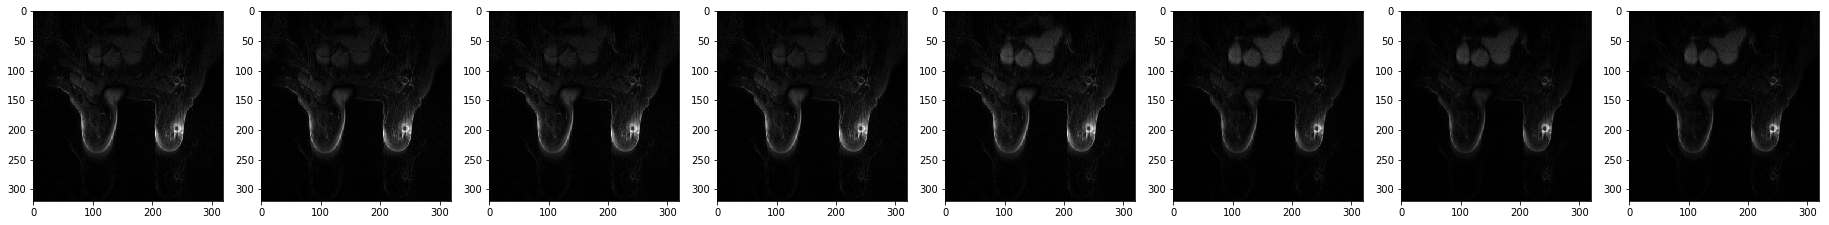

In [143]:
plotcoil(torch2numpy(cartesian_recon, complexdim=1))

0 alpha:  tensor([ 1.4211e+00, -2.6794e-08], device='cuda:0')
1 alpha:  tensor([ 2.2281e+00, -4.6829e-08], device='cuda:0')
2 alpha:  tensor([ 2.5016e+00, -4.0954e-08], device='cuda:0')


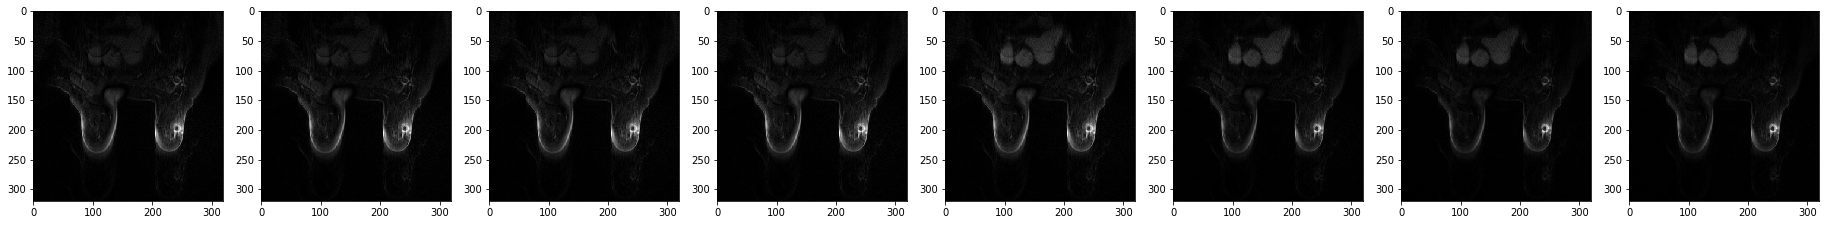

(22,)


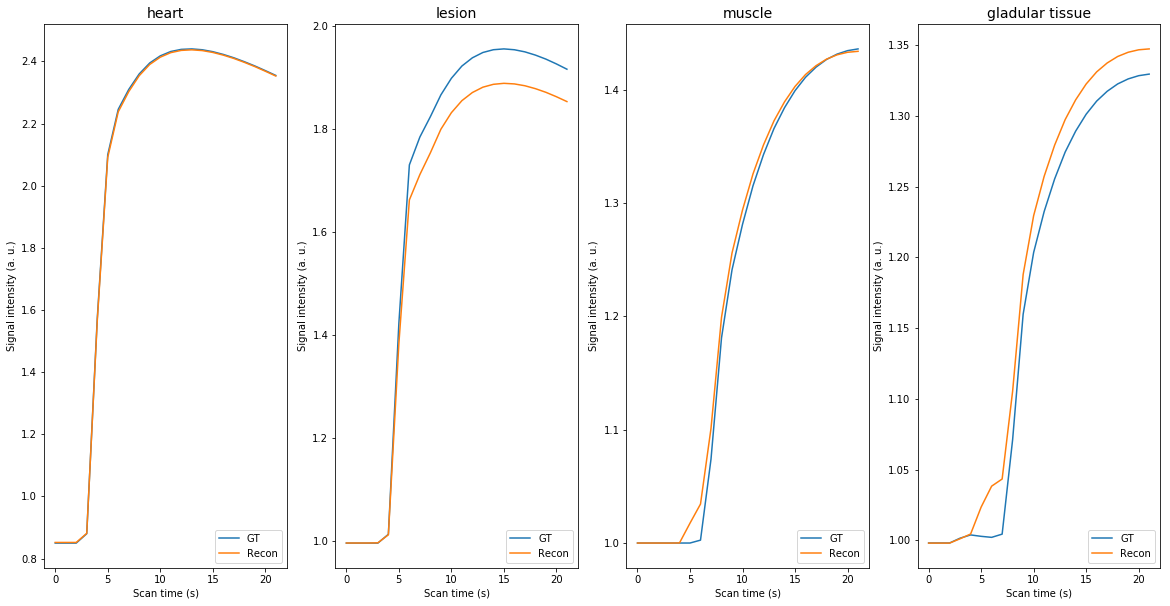

In [159]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 3)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.4211e+00, -2.6794e-08], device='cuda:0')
1 alpha:  tensor([ 2.2281e+00, -4.6829e-08], device='cuda:0')
2 alpha:  tensor([ 2.5016e+00, -4.0954e-08], device='cuda:0')
3 alpha:  tensor([ 3.5542e+00, -7.3062e-08], device='cuda:0')
4 alpha:  tensor([ 3.2493e+00, -7.7753e-08], device='cuda:0')
5 alpha:  tensor([ 3.1289e+00, -7.2495e-08], device='cuda:0')
6 alpha:  tensor([ 3.4084e+00, -6.4611e-08], device='cuda:0')
7 alpha:  tensor([ 3.3891e+00, -6.0036e-08], device='cuda:0')
8 alpha:  tensor([ 3.7794e+00, -7.9893e-08], device='cuda:0')
9 alpha:  tensor([ 3.6897e+00, -8.5328e-08], device='cuda:0')
10 alpha:  tensor([ 3.6222e+00, -7.9176e-08], device='cuda:0')
11 alpha:  tensor([ 4.1123e+00, -8.8604e-08], device='cuda:0')
12 alpha:  tensor([ 3.9977e+00, -9.5255e-08], device='cuda:0')
13 alpha:  tensor([ 4.1455e+00, -9.1604e-08], device='cuda:0')
14 alpha:  tensor([ 4.1131e+00, -9.6260e-08], device='cuda:0')
15 alpha:  tensor([ 4.0576e+00, -1.0301e-07], device='cuda:0')
16

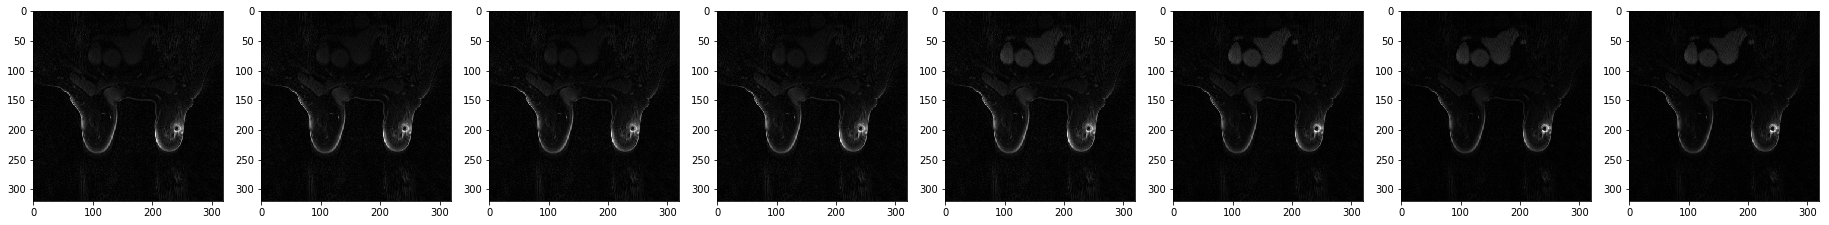

(22,)


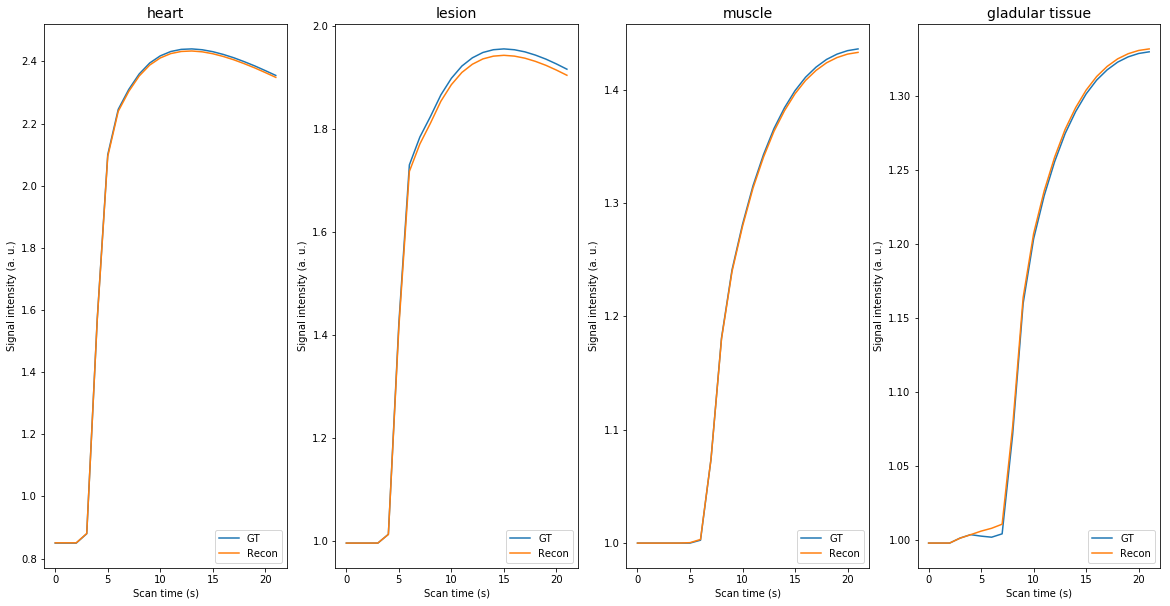

In [160]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 24)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.4211e+00, -2.6794e-08], device='cuda:0')
1 alpha:  tensor([ 2.2281e+00, -4.6829e-08], device='cuda:0')
2 alpha:  tensor([ 2.5016e+00, -4.0954e-08], device='cuda:0')
3 alpha:  tensor([ 3.5542e+00, -7.3062e-08], device='cuda:0')
4 alpha:  tensor([ 3.2493e+00, -7.7753e-08], device='cuda:0')
5 alpha:  tensor([ 3.1289e+00, -7.2495e-08], device='cuda:0')
6 alpha:  tensor([ 3.4084e+00, -6.4611e-08], device='cuda:0')
7 alpha:  tensor([ 3.3891e+00, -6.0036e-08], device='cuda:0')
8 alpha:  tensor([ 3.7794e+00, -7.9893e-08], device='cuda:0')
9 alpha:  tensor([ 3.6897e+00, -8.5328e-08], device='cuda:0')
10 alpha:  tensor([ 3.6222e+00, -7.9176e-08], device='cuda:0')
11 alpha:  tensor([ 4.1123e+00, -8.8604e-08], device='cuda:0')
12 alpha:  tensor([ 3.9977e+00, -9.5255e-08], device='cuda:0')
13 alpha:  tensor([ 4.1455e+00, -9.1604e-08], device='cuda:0')
14 alpha:  tensor([ 4.1131e+00, -9.6260e-08], device='cuda:0')
15 alpha:  tensor([ 4.0576e+00, -1.0301e-07], device='cuda:0')
16

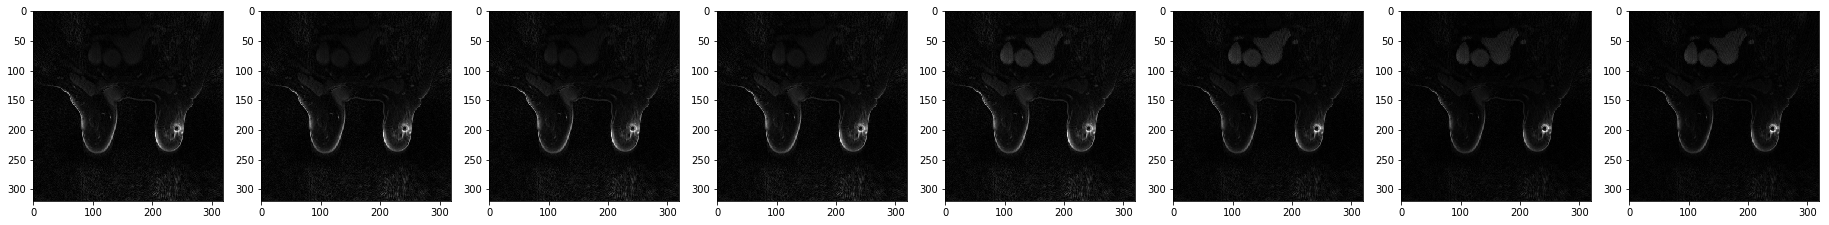

(22,)


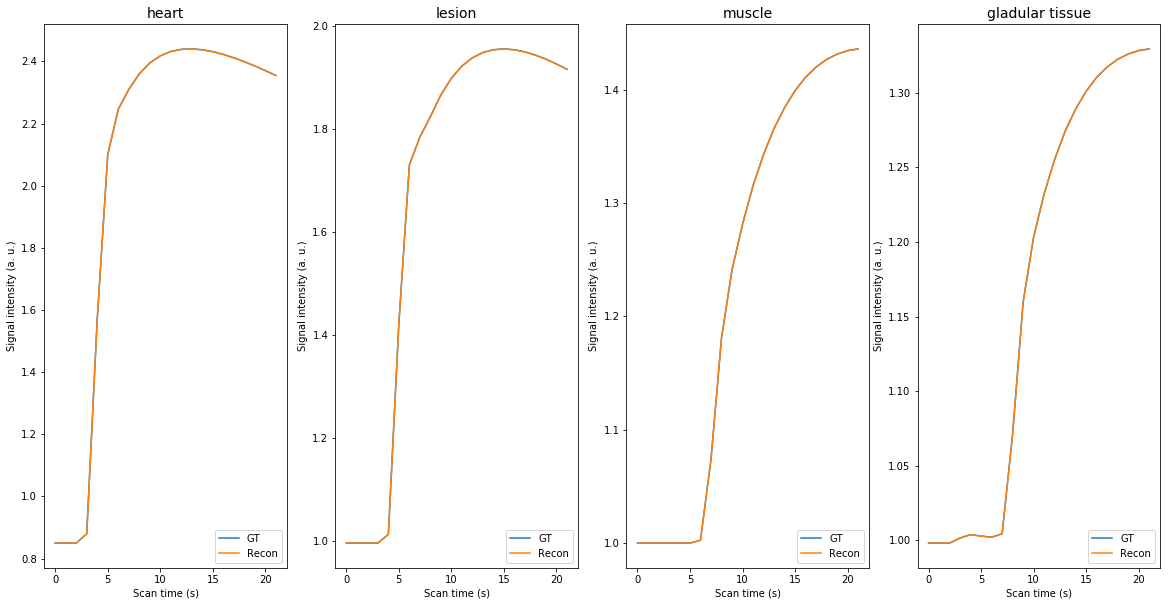

In [161]:
cartesian_recon, zerofilled = CartesianRecon(kspace= simulated_kspace_cartesian_4x, 
                                               coil_sensitivities = smap_loaded, #.permute(1, 0, 2, 3, 4), 
                                               w = cartesian_usmask.reshape((1, 1, 320, 320, 1)),
                                               optimizer = 'CG5', niter = 128)

plotcoil(torch2numpy(cartesian_recon, complexdim=1))

plotcurves(x_hat = np.abs(torch2numpy(cartesian_recon, complexdim=1)[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

(22,)


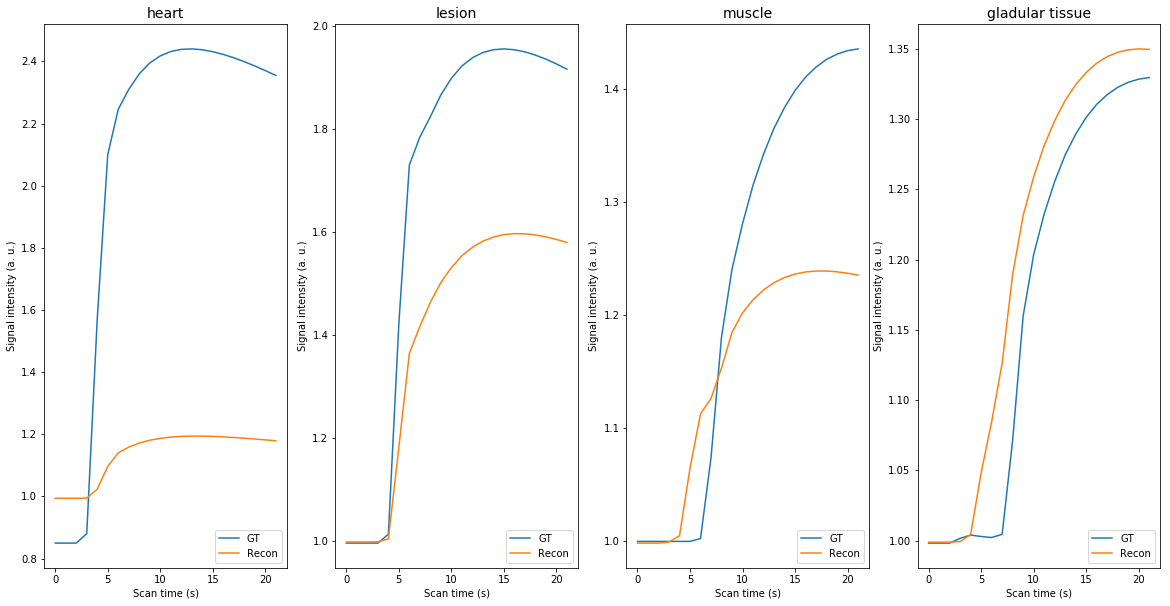

In [162]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = True)

(22,)


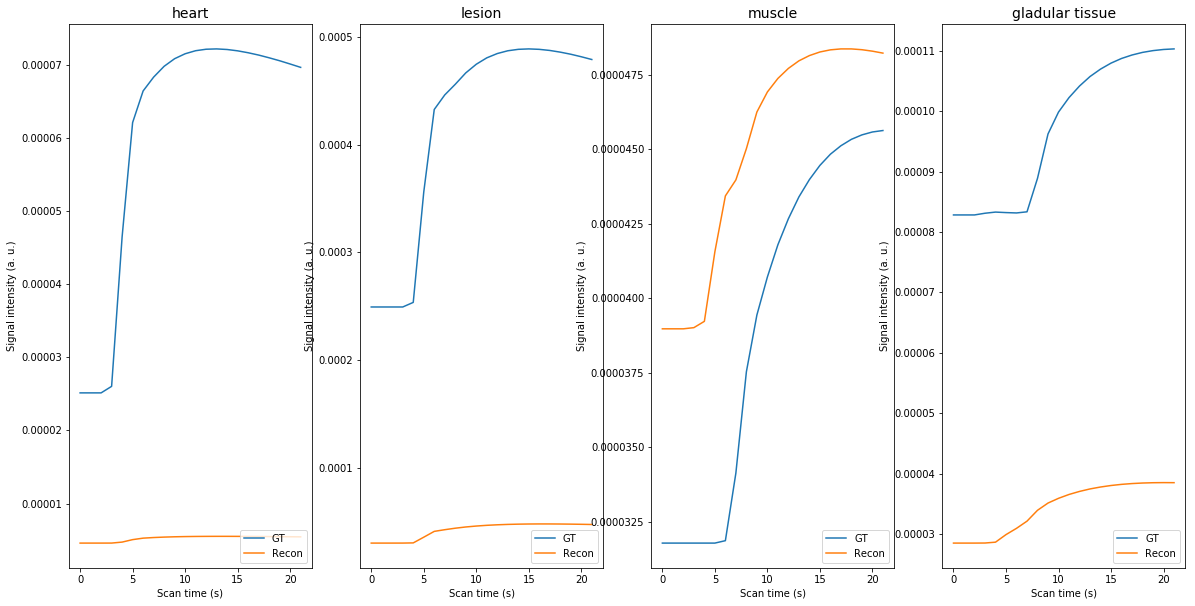

In [163]:
plotcurves(x_hat = np.abs(zerofilled[:,::-1,:]), 
           #x_gt = target_recombine[:,::-1,:], 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['Recon', 'GT'], 
           normalize = False)